In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 0 Read the Data
Data description:

- target: SalePrice
- We have 79 features, some of which have missing values
- We need to check the data types and distributions of each feature and the target

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
import scipy.stats as spst

import pylab
import missingno as msno

from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 300)

In [3]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
# y = df_train['SalePrice']
# df_train = df_train.drop('SalePrice', axis=1)
# df = pd.concat([df_train, df_test])

In [4]:
df_train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print(df_train.shape, df_test.shape)

(1460, 80) (1459, 79)


# 1 EDA

## 1.1 Variable Types
Totally there are 79 feature variables, including 33 numerical variables and 46 categorical variables. In detail, 14 are discrete, 20 are continuous, 23 are nominal, and 23 are ordinal.

In [6]:
#14
DISCRETE = ['BsmtFullBath','BsmtHalfBath','BedroomAbvGr','FullBath','Fireplaces','GarageYrBlt','GarageCars','HalfBath',
            'KitchenAbvGr','MoSold','TotRmsAbvGrd','YearBuilt','YearRemodAdd','YrSold']
#20
CONTINUOUS = ['1stFlrSF','2ndFlrSF','3SsnPorch','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','EnclosedPorch','GrLivArea',
              'GarageArea','LotArea','LotFrontage','LowQualFinSF','MasVnrArea','MiscVal','OpenPorchSF','PoolArea',
              'WoodDeckSF','ScreenPorch','TotalBsmtSF']
#23
NOMINAL = ['Alley','BldgType','Condition1','Condition2','CentralAir','Exterior1st','Exterior2nd','Foundation',
           'GarageType','HouseStyle','Heating','LandContour','LotConfig','MSSubClass','MSZoning','MasVnrType',
           'MiscFeature','Neighborhood','RoofStyle','RoofMatl','Street','SaleType','SaleCondition']
#23
ORDINAL = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','ExterCond','ExterQual','Electrical',
           'Functional','FireplaceQu','Fence','GarageFinish','GarageQual','GarageCond','HeatingQC','KitchenQual',
           'LotShape','LandSlope','OverallQual','OverallCond','PavedDrive','PoolQC','Utilities']

NUMERICAL = DISCRETE + CONTINUOUS
CATEGORICAL = NOMINAL + ORDINAL
print(len(DISCRETE),len(CONTINUOUS),len(NOMINAL),len(ORDINAL))
print(len(NUMERICAL), len(CATEGORICAL))

14 19 23 23
33 46


In [7]:
#some variables need to be transformed from int to str
df_train[CATEGORICAL].dtypes[df_train[CATEGORICAL].dtypes != object]

MSSubClass     int64
OverallQual    int64
OverallCond    int64
dtype: object

In [8]:
df_train[NUMERICAL].dtypes[df_train[NUMERICAL].dtypes == object]

Series([], dtype: object)

## 1.2 Missing Values

### 1.2.1 Variable Names and Missing Percentage

In [9]:
def plot_missing_percentage(df, note=True):
    num = sum(df.isnull().sum() != 0) #missing number
    missing_total = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / len(df)).sort_values(ascending=False)

    missing_total.head(num).plot(kind='barh', figsize=(16,10), fontsize=12)
    plt.xlabel('Number of missing values', fontsize=12)
    plt.title('Variables with missing values', fontsize=12)
    if note:
        for a,b,c in zip(range(num), missing_total.head(num), missing_percent.head(num)):
            plt.text(b+40, a, '%.3f' % c, ha='center', va='center', fontsize=12)
        
    return list(missing_total.head(num).index)

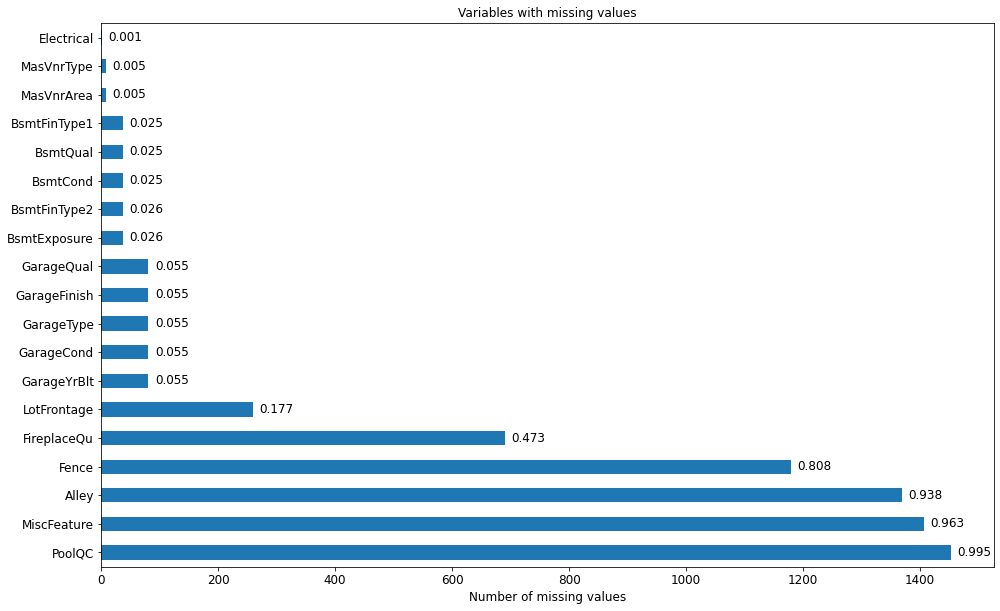

In [10]:
train_missing_list = plot_missing_percentage(df_train)

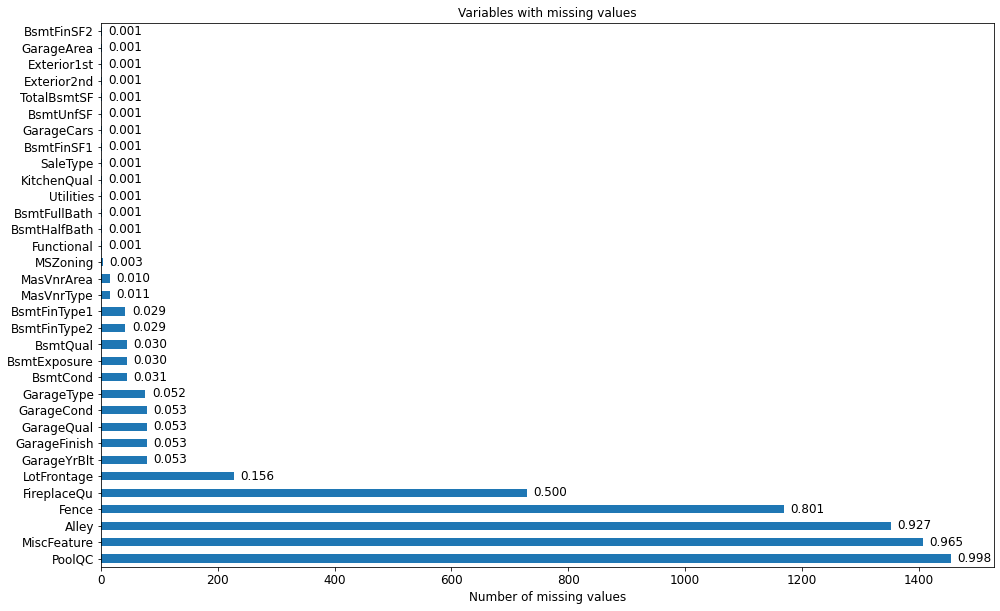

In [11]:
test_missing_list = plot_missing_percentage(df_test)

### 1.2.2 Missing Value Distribution

In [12]:
#check if there are missing values in train/test/both
train_test_missing_both = []
train_missing_only = []
test_missing_only = []

for var in set(train_missing_list + test_missing_list):
    if var in train_missing_list:
        if var in test_missing_list: train_test_missing_both.append(var)
        else: train_missing_only.append(var)
    else: test_missing_only.append(var)

In [13]:
set(train_test_missing_both)

{'Alley',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Fence',
 'FireplaceQu',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'MasVnrType',
 'MiscFeature',
 'PoolQC'}

In [14]:
set(train_missing_only)

{'Electrical'}

In [15]:
set(test_missing_only)

{'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'Exterior1st',
 'Exterior2nd',
 'Functional',
 'GarageArea',
 'GarageCars',
 'KitchenQual',
 'MSZoning',
 'SaleType',
 'TotalBsmtSF',
 'Utilities'}

#### Discrete Variables

<AxesSubplot:>

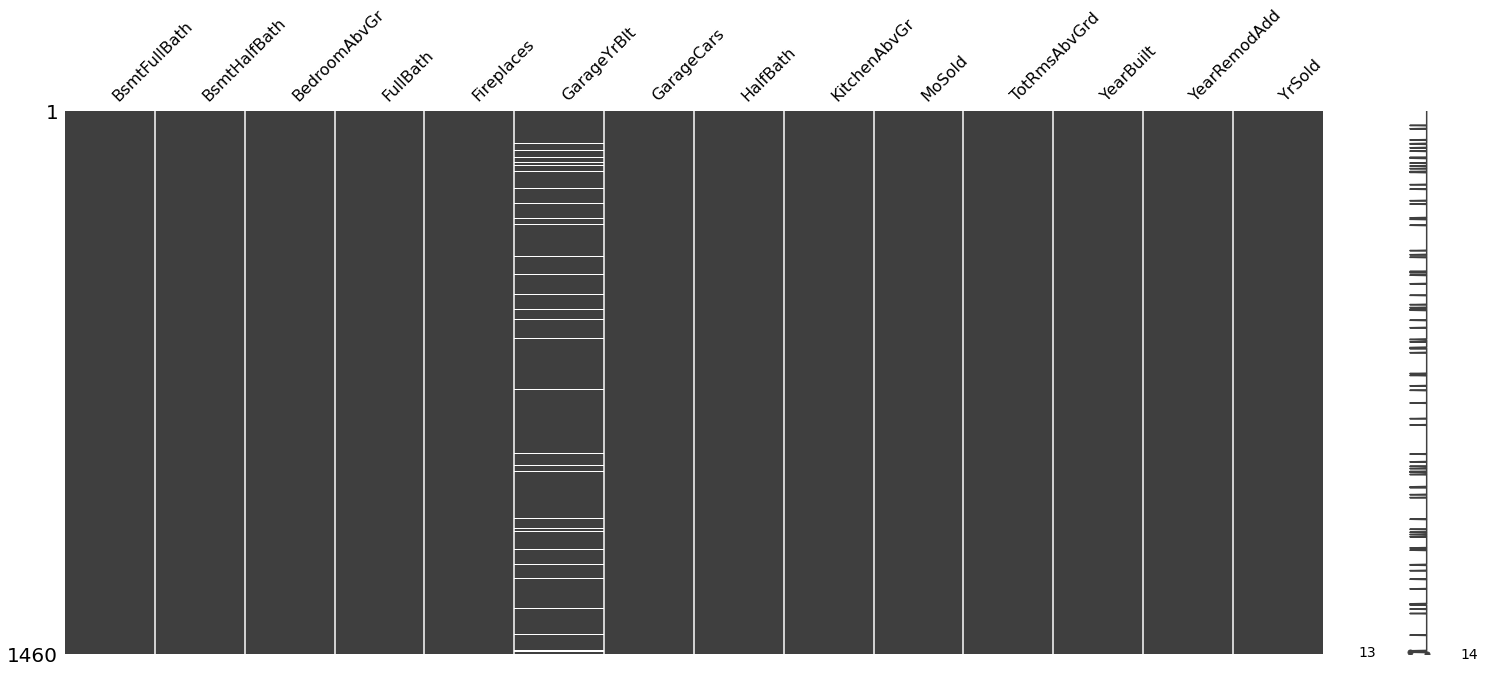

In [16]:
msno.matrix(df_train[DISCRETE])

<AxesSubplot:>

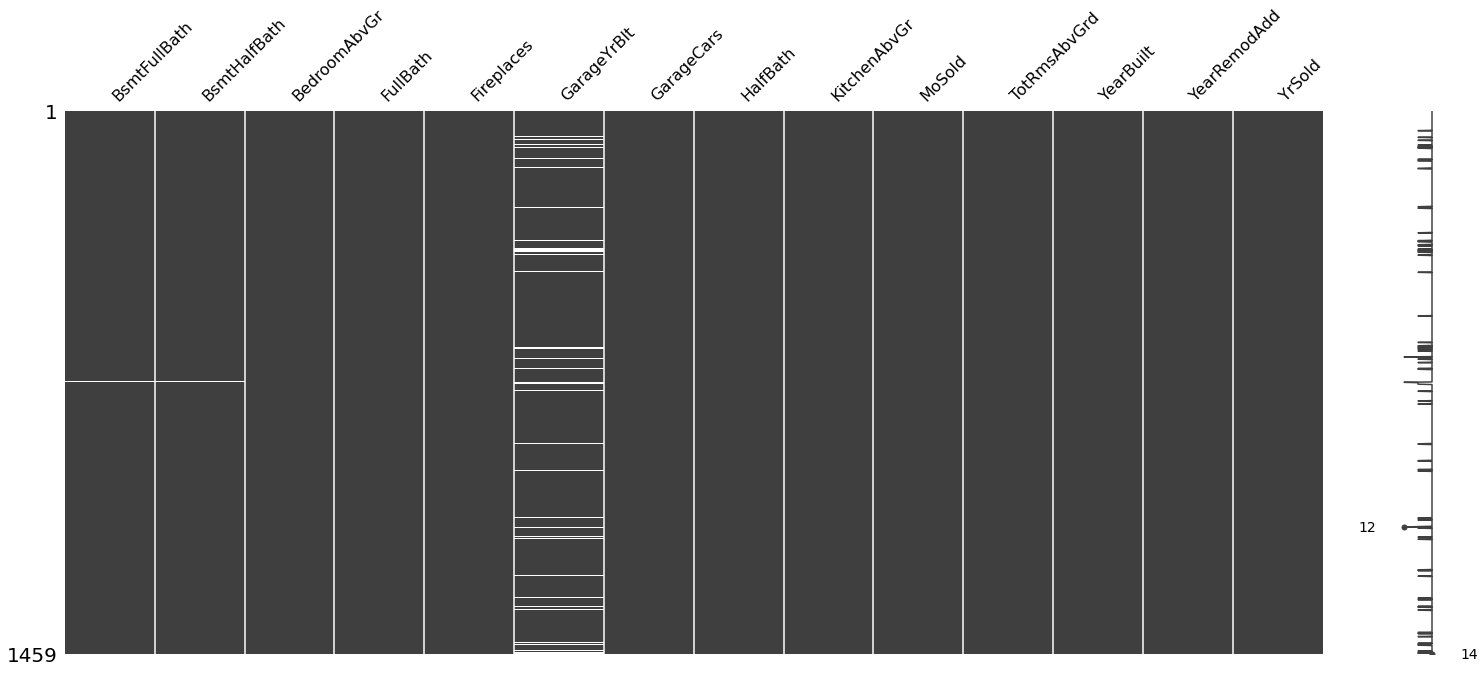

In [17]:
msno.matrix(df_test[DISCRETE])

#### Continuous Variables

<AxesSubplot:>

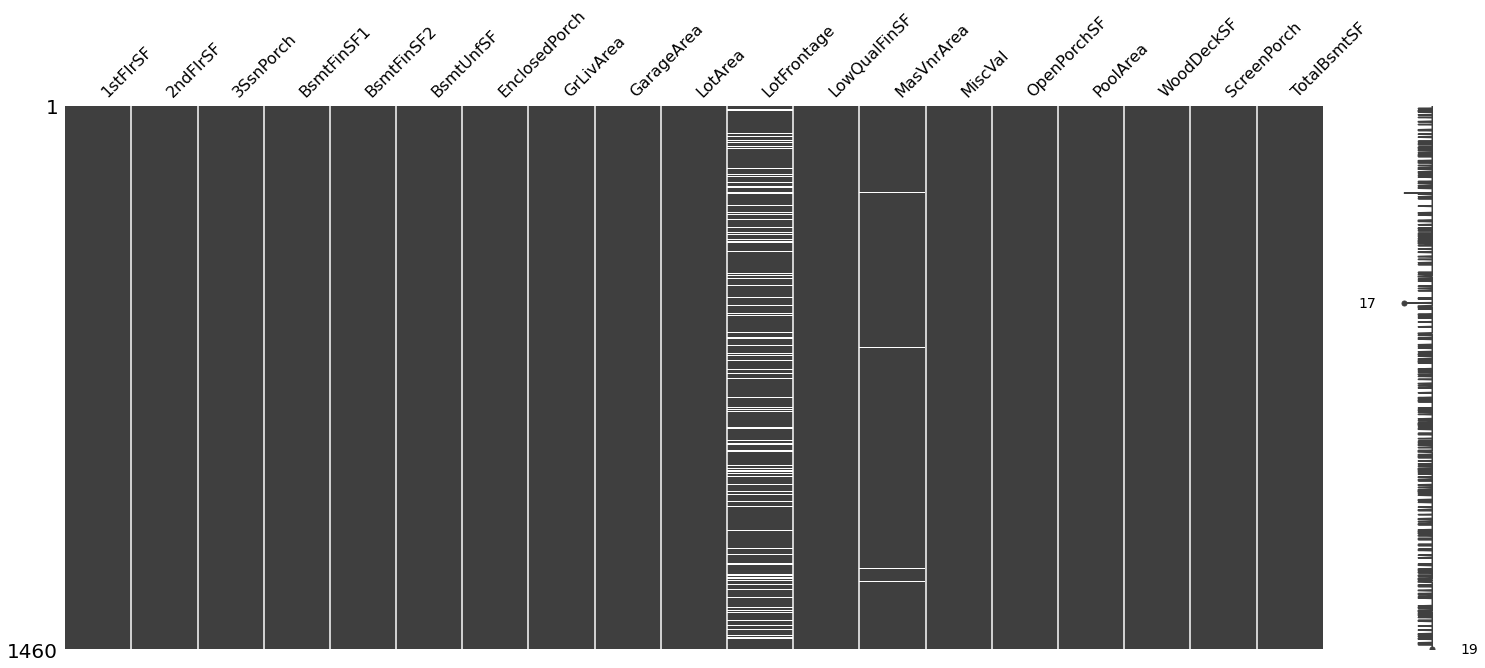

In [18]:
msno.matrix(df_train[CONTINUOUS])

<AxesSubplot:>

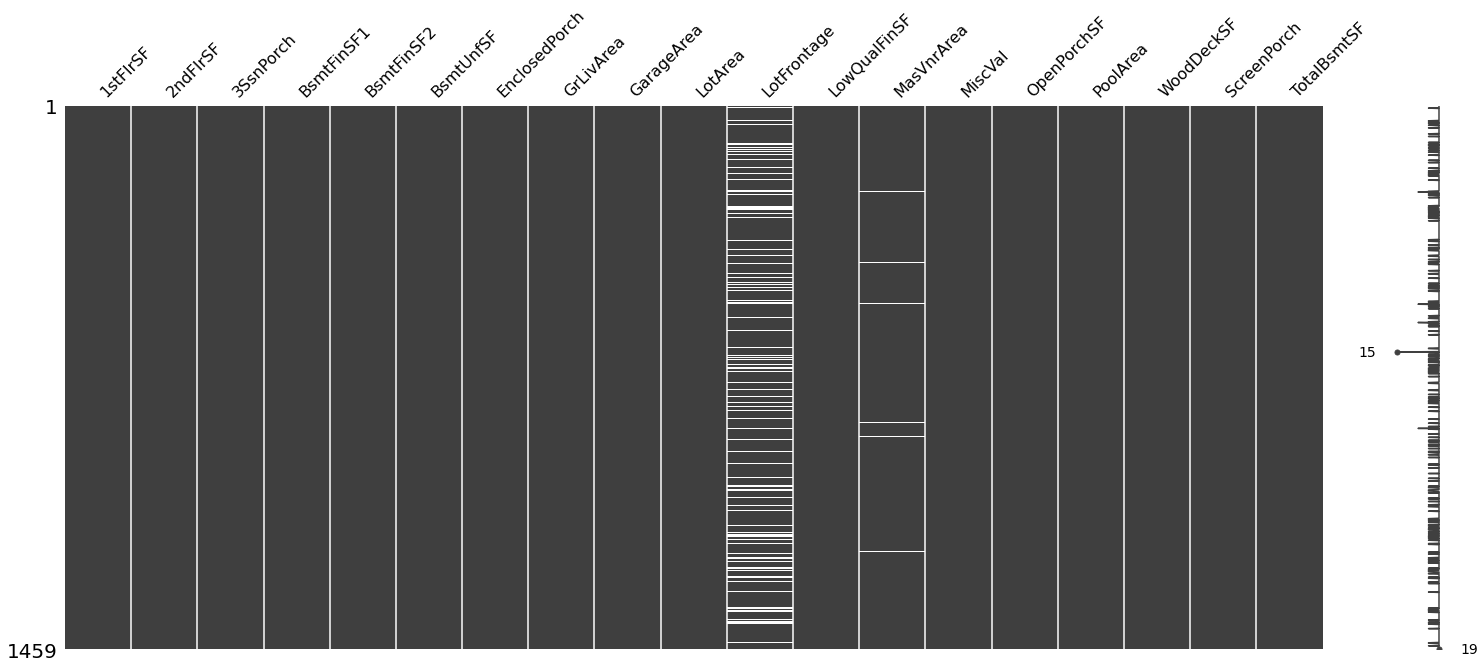

In [19]:
msno.matrix(df_test[CONTINUOUS])

#### Nominal Variables

<AxesSubplot:>

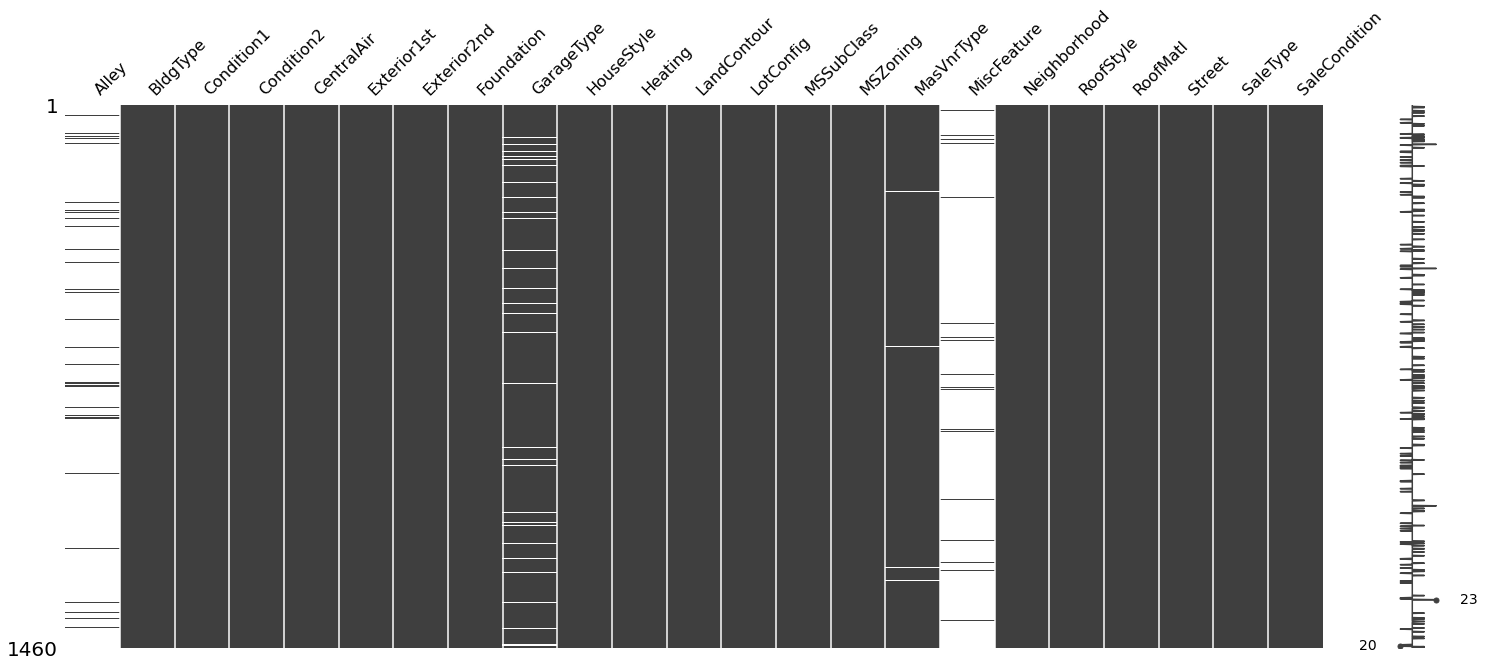

In [20]:
msno.matrix(df_train[NOMINAL])

<AxesSubplot:>

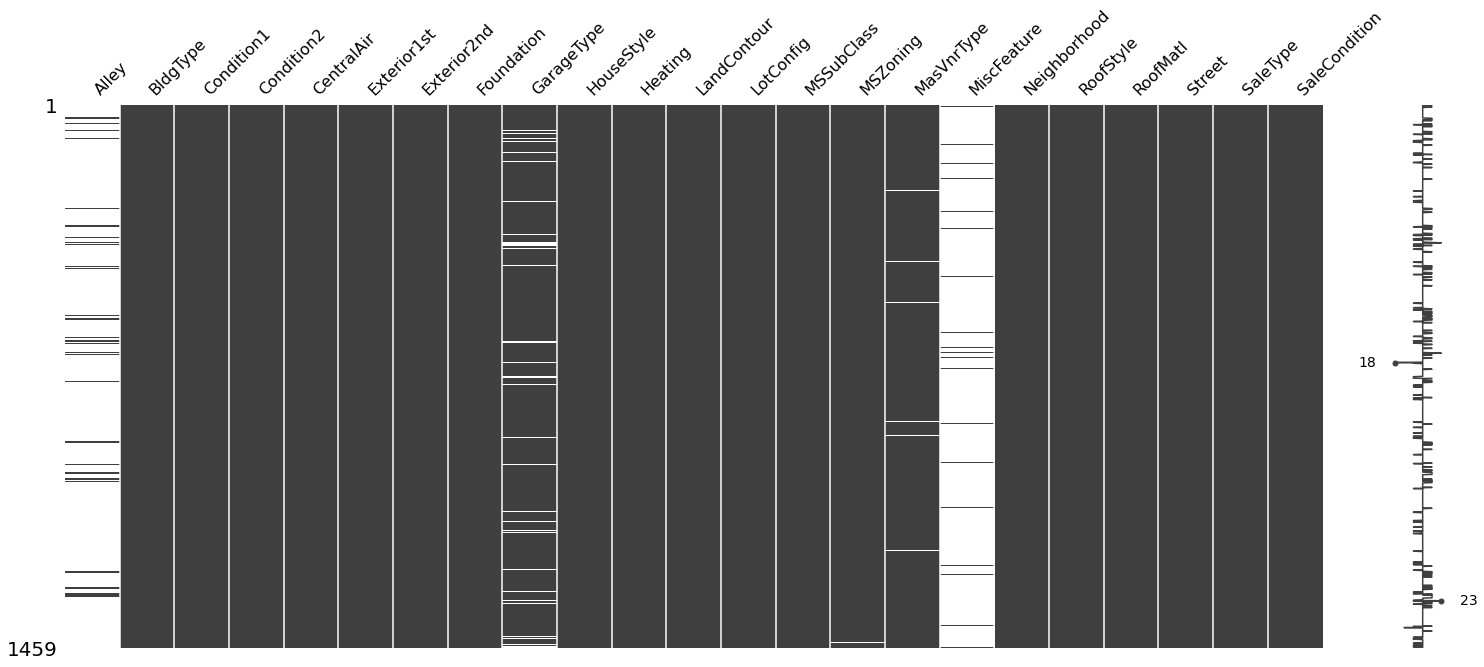

In [21]:
msno.matrix(df_test[NOMINAL])

#### Ordinal Variables

<AxesSubplot:>

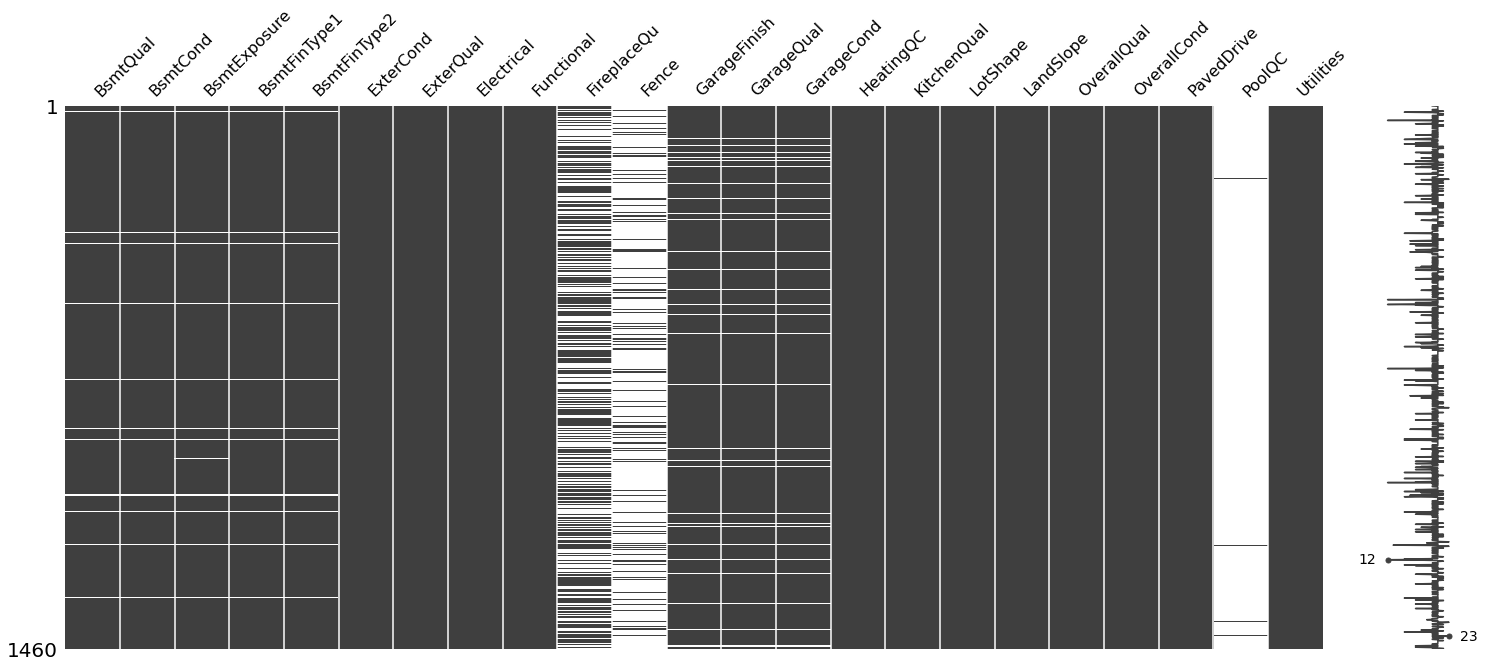

In [22]:
msno.matrix(df_train[ORDINAL])

<AxesSubplot:>

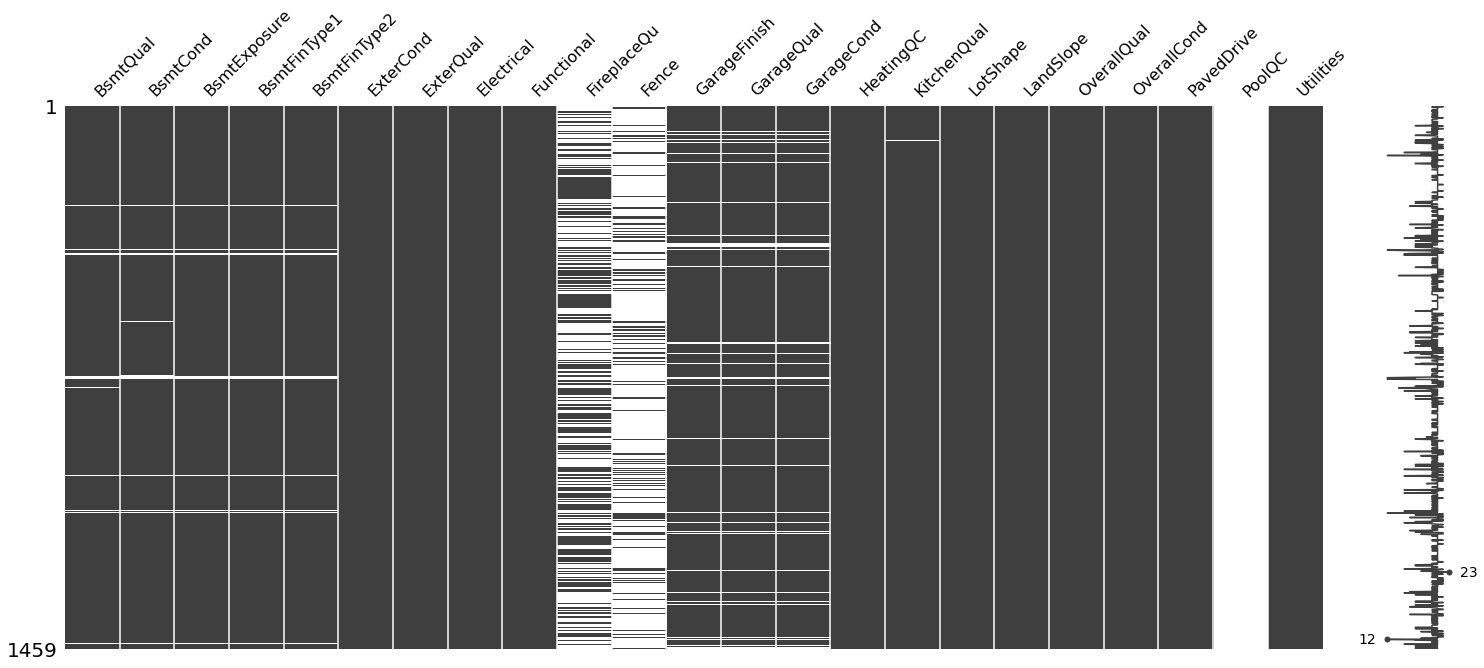

In [23]:
msno.matrix(df_test[ORDINAL])

### 1.2.3 Deal with Missing Values
Although we found that some variables have too many missing values (PoolQC, MiscFeature, Alley), we just keep them here in case there are other analysis related to them later. If a variable has little information, it can be eliminated by outlier detection or using feature selection techniques before modelling anyway.

To avoid data leakage, here we do data imputation only based on train set, which also means that we assume that test set has the same data distribution as train set.

- test_missing_only: not a lot of missing values for each variable, but cannot drop the rows, try to impute
    - impute with 0: 
        - BsmtFinSF1, BsmtFinSF2, BsmtFullBath, BsmtHalfBath, BsmtUnfSF, TotalBsmtSF
        - GarageArea, GarageCars
    - impute with mode: 
        - Exterior1st, Exterior2nd
        - Functional, KitchenQual, MSZoning, SaleType, Utilities
        
- train_missing_only
    - impute with mode: 
        - Electrical

- train_test_missing_both
    - impute with 'None': 
        - Alley, Fence, FireplaceQu, PoolQC, MiscFeature
        - BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, BsmtQual
        - GarageCond, GarageFinish, GarageQual, GarageType, GarageYrBlt
    - impute with median: 
        - LotFrontage
        - MasVnrArea
    - impute with mode:
        - MasVnrType

#### Basement-related Variables Error
**Note**: From the above matrix plots built with missingno, we can see that there may be some data errors in basement-related variables: 
- If a house doesn't have a basement, all the basement-related variables should be NaN. However, we can check that some samples don't satisfy this rule. We can fix them with the mode using other basement-related variables.
- Actually I guess there won't be much effect, but since we saw this issue, we can fix it here.
    - impute id=949 in df_train with BsmtExposure='No'
    - impute id=333 in df_train with BsmtFinType2='Unf'

In [24]:
bsmt_related_vars = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 
                     'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
df_train[bsmt_related_vars].isnull().sum()

BsmtFinSF1       0
BsmtFinSF2       0
BsmtFullBath     0
BsmtHalfBath     0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtQual        37
dtype: int64

In [25]:
df_train[bsmt_related_vars][df_train['BsmtCond'].notnull() & df_train['BsmtExposure'].isnull()]

,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
Id,,,,,,,,,,,
949,0,0,0,0,936,936,TA,NaN,Unf,Unf,Gd


In [26]:
df_train[bsmt_related_vars][(df_train['BsmtCond']=='TA') & (df_train['BsmtFinType1']=='Unf') & 
                            (df_train['BsmtFinType2']=='Unf') & (df_train['BsmtQual']=='Gd')]['BsmtExposure'].mode()[0]

'No'

In [27]:
df_train[bsmt_related_vars][df_train['BsmtCond'].notnull() & df_train['BsmtFinType2'].isnull()]

,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
Id,,,,,,,,,,,
333,1124,479,1,0,1603,3206,TA,No,GLQ,NaN,Gd


In [28]:
df_train[bsmt_related_vars][(df_train['BsmtCond']=='TA') & (df_train['BsmtFinType1']=='GLQ') & 
                            (df_train['BsmtExposure']=='No') & (df_train['BsmtQual']=='Gd')]['BsmtFinType2'].mode()[0]

'Unf'

#### LotFrontage
**Note**: LotFrontage is a little bit special since it has many missing values and it may not be very accurate to impute all of them with median. A more reasonable way is to impute them with median in the corresponding neighborhood since we can assume that the lot frontages of different houses in the same neighborhood are the same or close to each other.

In [29]:
# aaa = df_train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))
# df_median = df_train.groupby('Neighborhood')['LotFrontage'].median()
# bbb = df_train['LotFrontage'].fillna(df_train.reset_index().merge(df_median, on='Neighborhood', how='left').set_index('Id')['LotFrontage_y'])
# sum(aaa==bbb)

### 1.2.4 Get Cleaned Data

In [30]:
#deal with missing values
def data_cleaning(df_train, df_test):
    clean_train = df_train.copy()
    clean_test = df_test.copy()
    
    #train
    ##fix id=949 and id=333
    clean_train.loc[949, 'BsmtExposure'] = clean_train[(clean_train['BsmtQual']=='Gd') & 
                                                       (clean_train['BsmtCond']=='TA') & 
                                                       (clean_train['BsmtFinType1']=='Unf') & 
                                                       (clean_train['BsmtFinType2']=='Unf')]['BsmtExposure'].mode()[0]
    
    clean_train.loc[333, 'BsmtFinType2'] = clean_train[(clean_train['BsmtCond']=='TA') & 
                                                       (clean_train['BsmtFinType1']=='GLQ') & 
                                                       (clean_train['BsmtExposure']=='No') & 
                                                       (clean_train['BsmtQual']=='Gd')]['BsmtFinType2'].mode()[0]
    ##impute with 0
    clean_train['GarageYrBlt'].fillna(0, inplace=True)
 
    ##impute with mode
    for col in ['Electrical', 'MasVnrType']:
        clean_train[col].fillna(clean_train[col].mode()[0], inplace=True)
    
    ##impute with 'None'
    for col in ['Alley', 'Fence', 'FireplaceQu', 'PoolQC', 'MiscFeature', 
                'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
                'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
        clean_train[col].fillna('None', inplace=True)
        
    ##impute with median
    clean_train['MasVnrArea'].fillna(clean_train['MasVnrArea'].median(), inplace=True)
    
    ##LotFrontage: impute with median in each neighborhood
    df_median = df_train.groupby('Neighborhood')['LotFrontage'].median()
    clean_train['LotFrontage'] = clean_train['LotFrontage'].fillna(clean_train.reset_index().merge(df_median, on='Neighborhood', how='left').set_index('Id')['LotFrontage_y'])
    
    
    #test
    ##impute with 0
    for col in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 
                'GarageArea', 'GarageCars', 'GarageYrBlt']:
        clean_test[col].fillna(0, inplace=True)
    
    ##impute with 'None'
    for col in ['Alley', 'Fence', 'FireplaceQu', 'PoolQC', 'MiscFeature', 
                'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 
                'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType']:
        clean_test[col].fillna('None', inplace=True)
    
    ##impute with mode
    for col in ['Exterior1st', 'Exterior2nd', 
                'Functional', 'KitchenQual', 'MSZoning', 'SaleType', 'Utilities', 
                'MasVnrType']:
        clean_test[col].fillna(clean_train[col].mode()[0], inplace=True)
    
    ##impute with median
    clean_test['MasVnrArea'].fillna(clean_train['MasVnrArea'].median(), inplace=True)
    
    ##LotFrontage: impute with median in each neighborhood
    clean_test['LotFrontage'] = clean_test['LotFrontage'].fillna(clean_test.reset_index().merge(df_median, on='Neighborhood', how='left').set_index('Id')['LotFrontage_y'])

    return clean_train, clean_test
    

In [31]:
df_tr, df_te = data_cleaning(df_train, df_test)

In [32]:
print(sum(df_tr.isnull().sum()))
print(sum(df_te.isnull().sum()))

0
0


In [33]:
df_tr[DISCRETE] = df_tr[DISCRETE].astype(np.int64)
df_te[DISCRETE] = df_te[DISCRETE].astype(np.int64)
df_tr[CONTINUOUS] = df_tr[CONTINUOUS].astype(np.float64)
df_te[CONTINUOUS] = df_te[CONTINUOUS].astype(np.float64)
df_tr['MSSubClass'] = df_tr['MSSubClass'].astype(str)
df_te['MSSubClass'] = df_te['MSSubClass'].astype(str)

## 1.3 Variable Dependency
There are some internal relationships between variables:
- GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF, which is the total area square feet above ground
- TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF, which is the total basement square feet

In [34]:
print(sum(df_tr['GrLivArea'] == df_tr['1stFlrSF'] + df_tr['2ndFlrSF'] + df_tr['LowQualFinSF']))
print(sum(df_te['GrLivArea'] == df_te['1stFlrSF'] + df_te['2ndFlrSF'] + df_te['LowQualFinSF']))

1460
1459


In [35]:
print(sum(df_tr['TotalBsmtSF'] == df_tr['BsmtFinSF1'] + df_tr['BsmtFinSF2'] + df_tr['BsmtUnfSF']))
print(sum(df_te['TotalBsmtSF'] == df_te['BsmtFinSF1'] + df_te['BsmtFinSF2'] + df_te['BsmtUnfSF']))

1460
1459


In [36]:
#room-related variables don't have such dependency
print(sum(df_tr["TotRmsAbvGrd"] == df_tr["BedroomAbvGr"] + df_tr["KitchenAbvGr"] + df_tr["FullBath"]))
print(sum(df_te["TotRmsAbvGrd"] == df_te["BedroomAbvGr"] + df_te["KitchenAbvGr"] + df_te["FullBath"]))

419
424


## 1.4 Target variable: SalePrice
- SalePrice is not normally distributed, which can be a problem for some regression algorithms
    - skewness > 1, highly positive skewed
    - kurtosis > 3, heavy-tailed with outliers
- Log transformation is needed to reduce the skewness of our original data. (the original data approximately follow a log-normal distribution)

In [37]:
df_tr['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [38]:
print('Skewness: %f' % df_tr['SalePrice'].skew())
print('Kurtosis: %f' % df_tr['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [39]:
def dist_prob_plot(s):
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    sns.distplot(s, fit=norm, ax=ax[0])
    ax[1] = spst.probplot(s, dist="norm", plot=pylab) #Q-Q plot

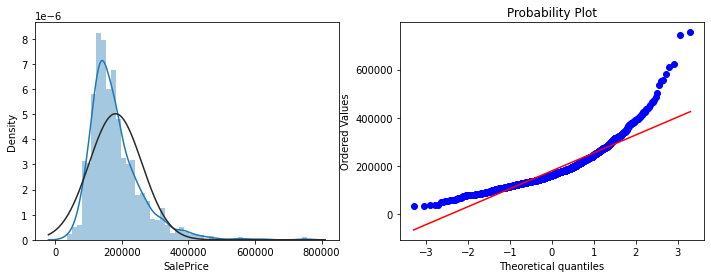

In [40]:
dist_prob_plot(df_tr['SalePrice'])

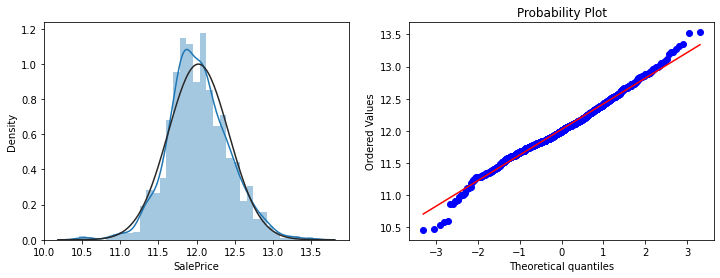

In [41]:
#after log transformation
dist_prob_plot(np.log1p(df_tr['SalePrice']))

## 1.5 Variable Distributions

### 1.5.1 Simple Visualizations

In [42]:
def numerical_plot(df, feature_list, row_num, col_num, figsize=(20,20)):
    fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
    for i, col_name in enumerate(feature_list):
        ax = axes[int(i/col_num), i%col_num]
        sns.distplot(df[col_name], fit=norm, ax=ax)
        ax.set_title(col_name)
    plt.tight_layout()
    
def categorical_plot(df, feature_list, row_num, col_num, figsize=(20,20), kind='bar'):
    fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
    for i, col_name in enumerate(feature_list):
        ax = axes[int(i/col_num), i%col_num]
        df[col_name].value_counts(sort=False, dropna=False).plot(kind=kind, ax=ax)
        ax.set_title(col_name)
    plt.tight_layout()

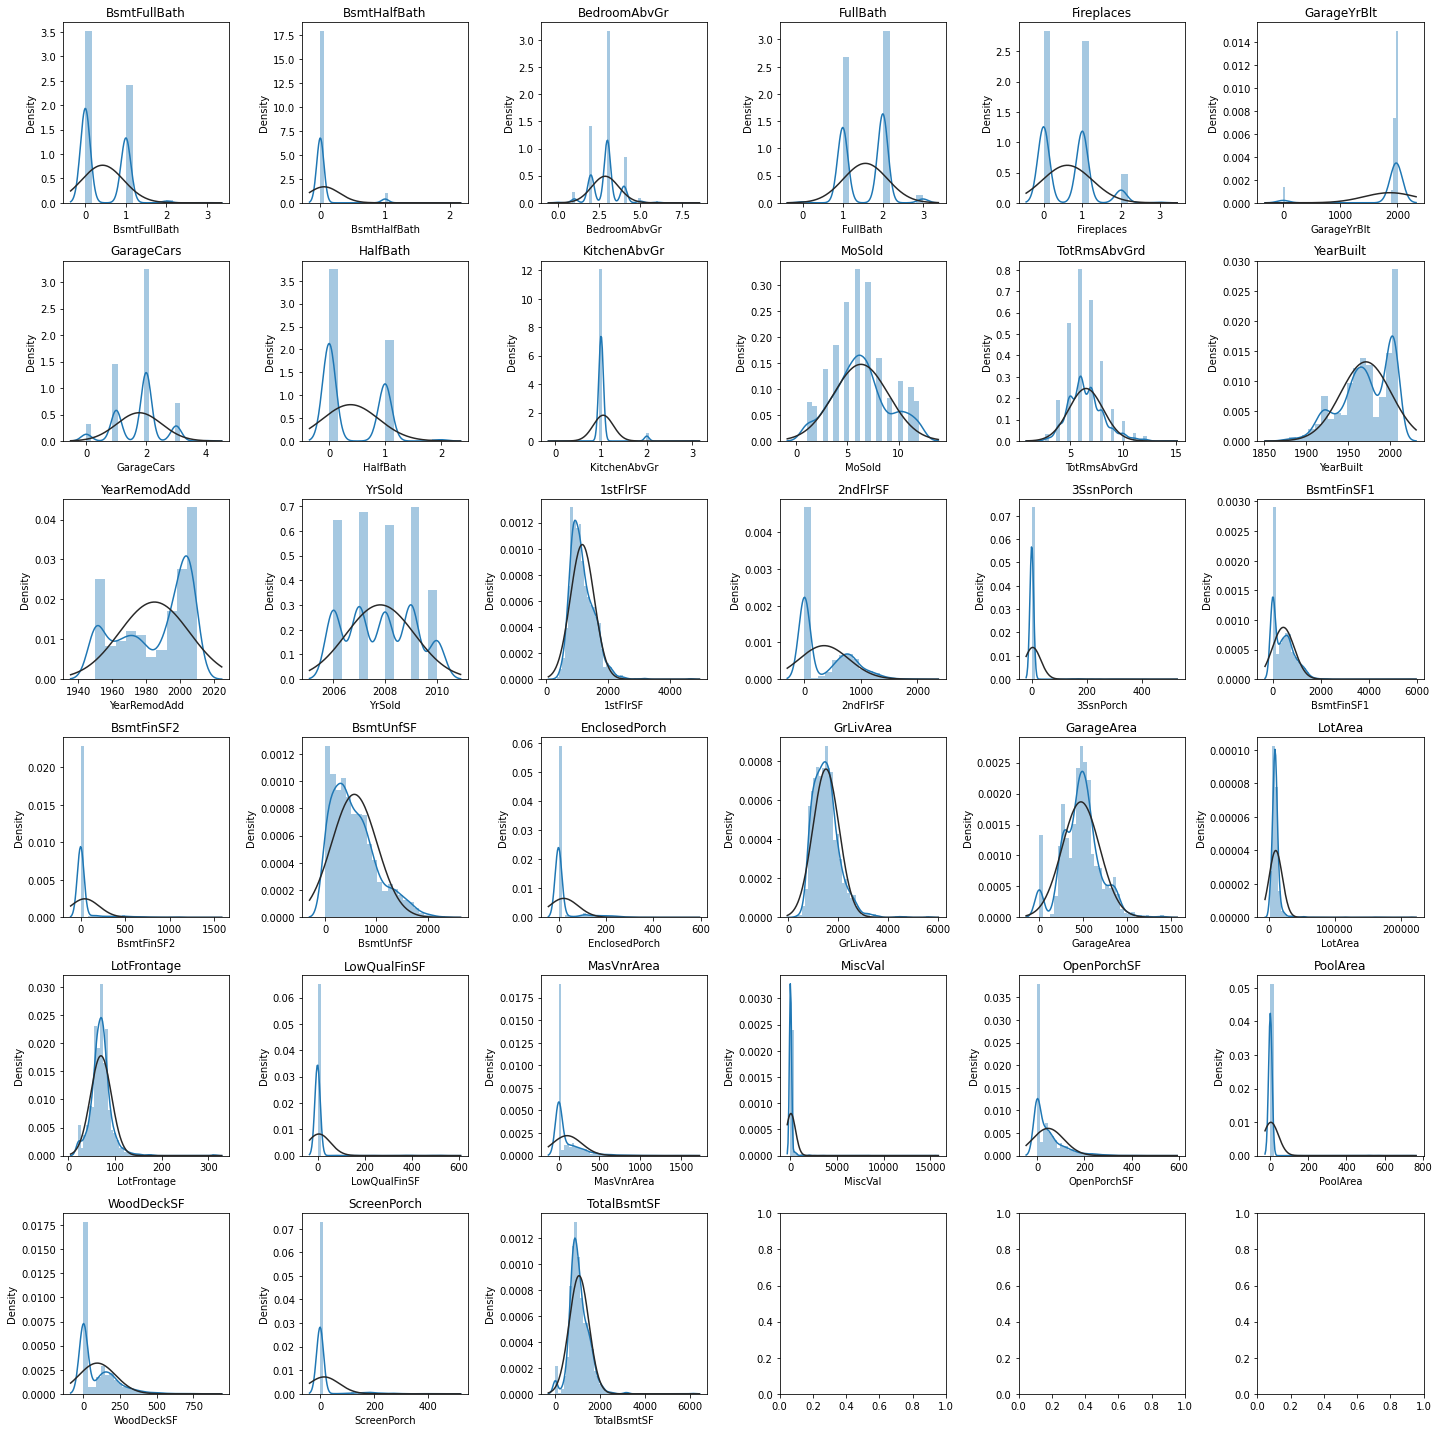

In [43]:
numerical_plot(df_tr, NUMERICAL, 6, 6, figsize=(20,20))

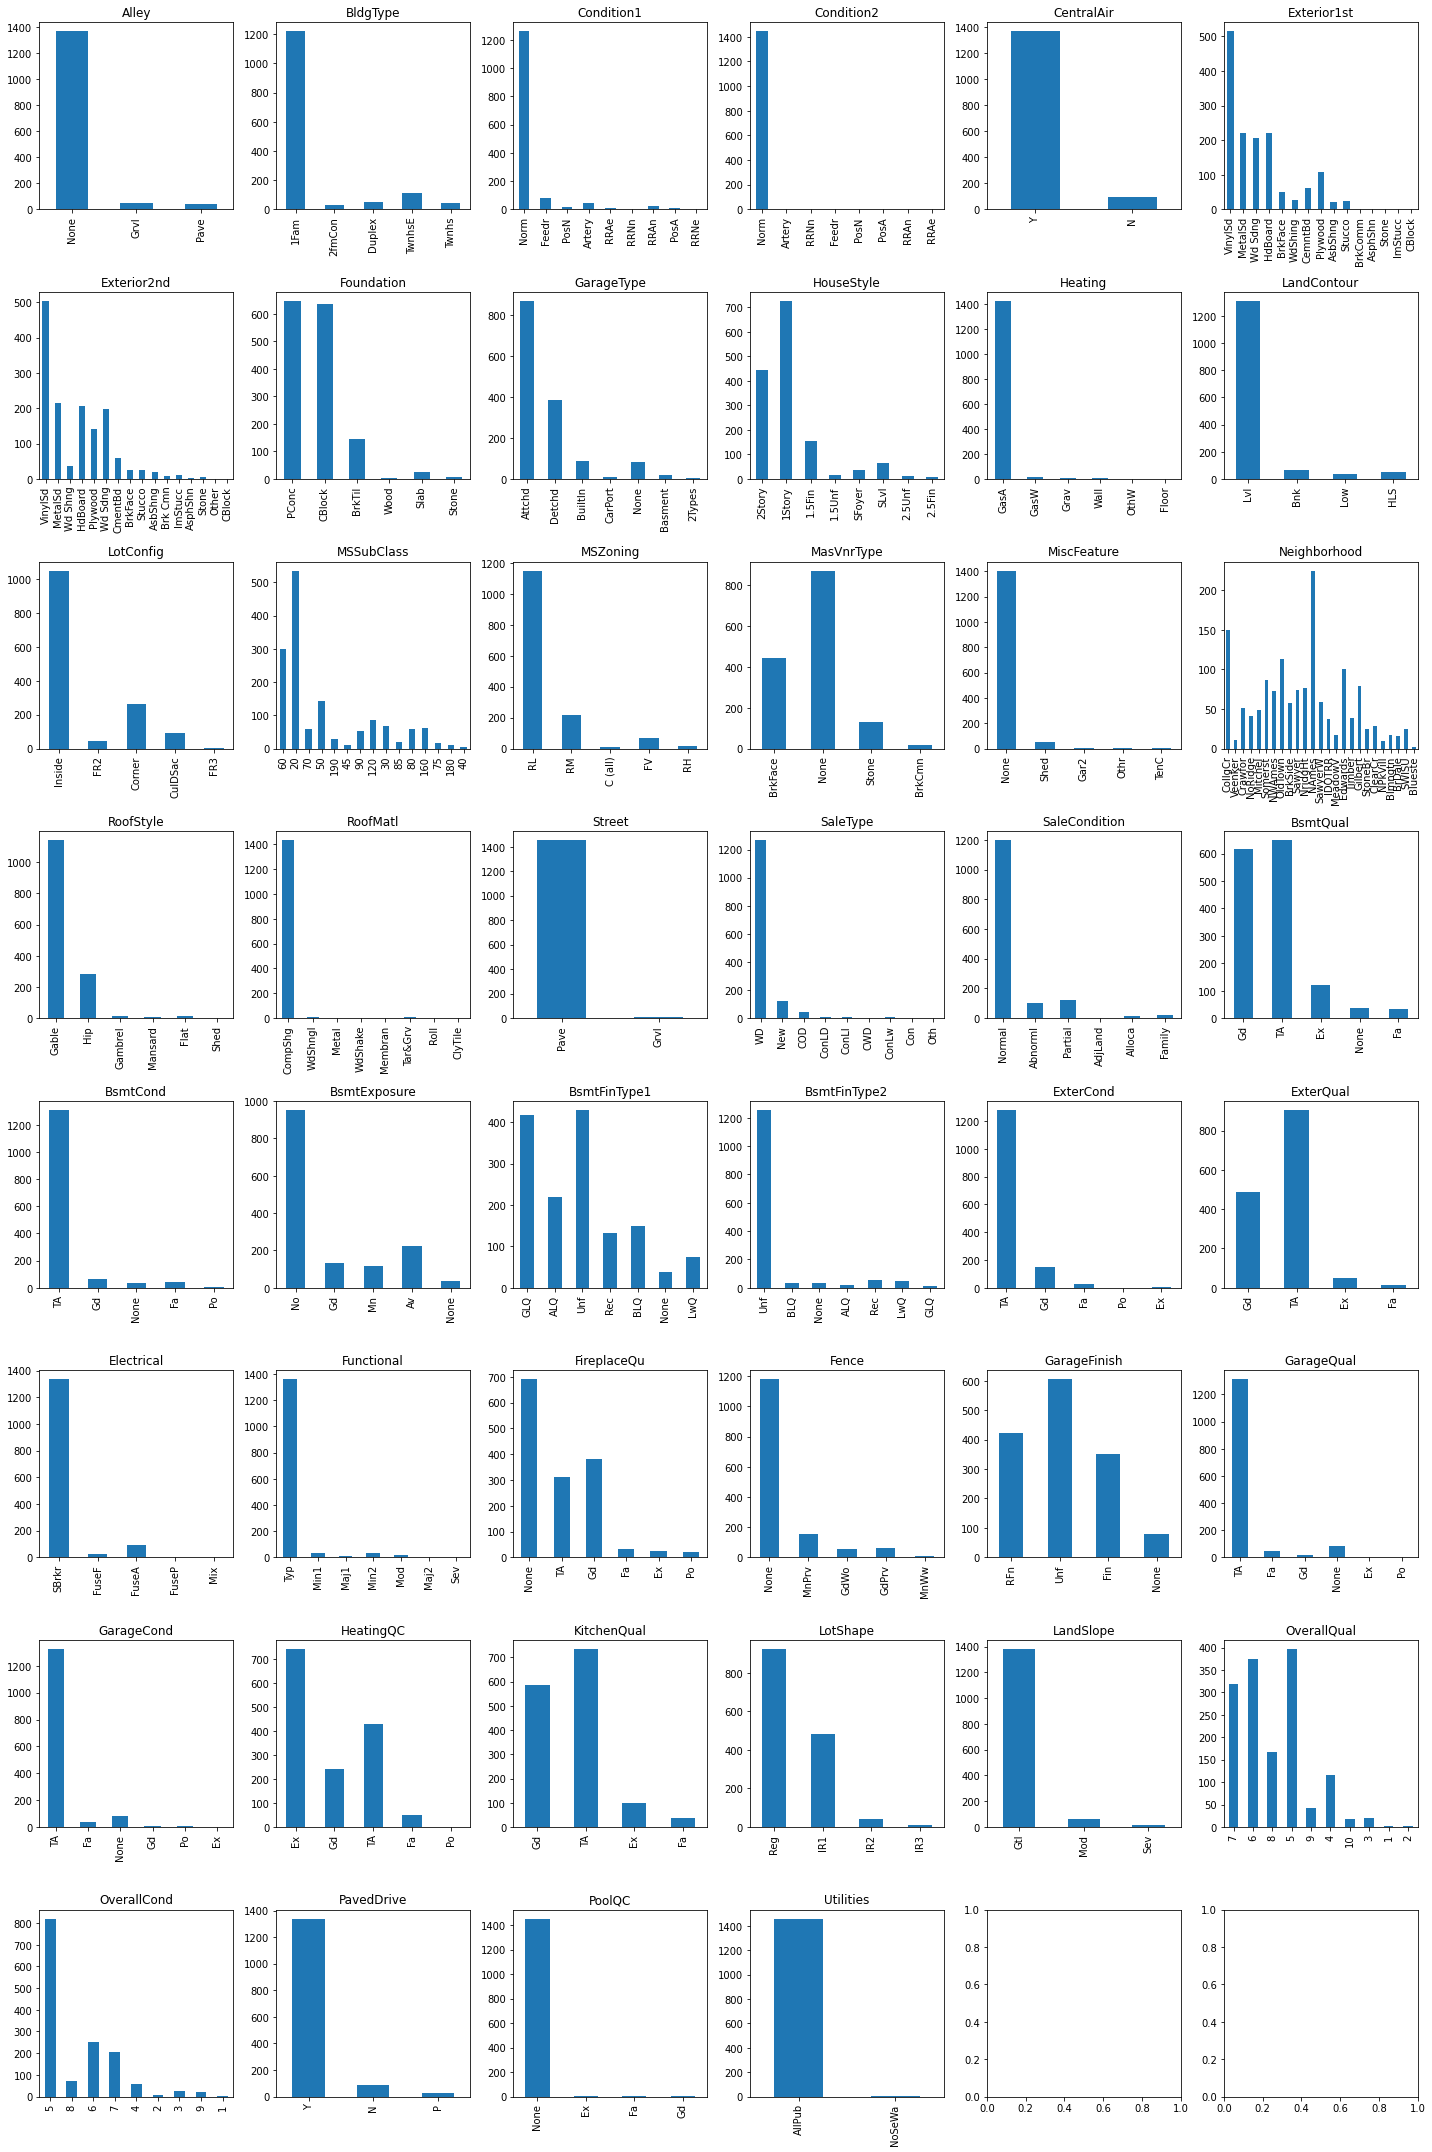

In [44]:
categorical_plot(df_tr, CATEGORICAL, 8, 6, figsize=(20,30), kind='bar')

### 1.5.2 Normality of Continuous Variables
In regression models, we want each variable to be normally distributed. If not, we can consider to apply [Box-Cox transformation](https://www.statisticshowto.com/box-cox-transformation/) on such variables whose values are always positive.

In [45]:
pt_cols = list(df_tr[CONTINUOUS].min()[df_tr[CONTINUOUS].min()>0].index)
pt = PowerTransformer(method='box-cox', standardize=False)
pt.fit(df_tr[pt_cols])
for i in range(len(pt_cols)):
    print("{} lambda={}".format(pt_cols[i], pt.lambdas_[i]))

1stFlrSF lambda=-0.07883214484264238
GrLivArea lambda=0.006304841218621503
LotArea lambda=0.03094631071248529
LotFrontage lambda=0.4643187672048936


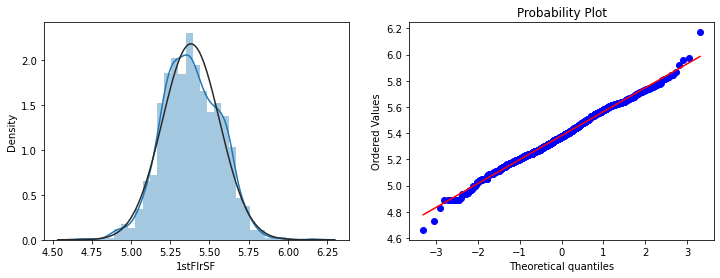

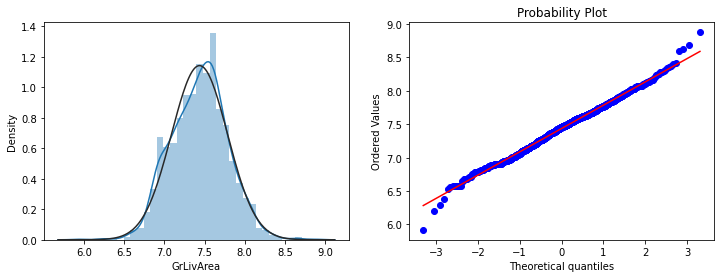

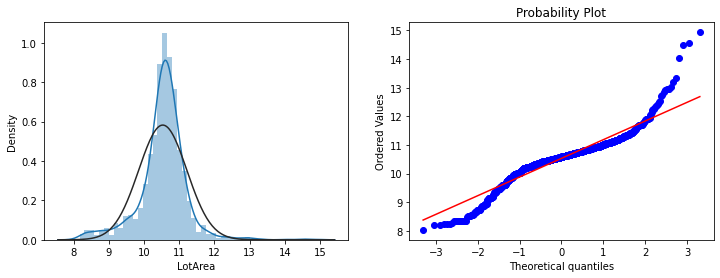

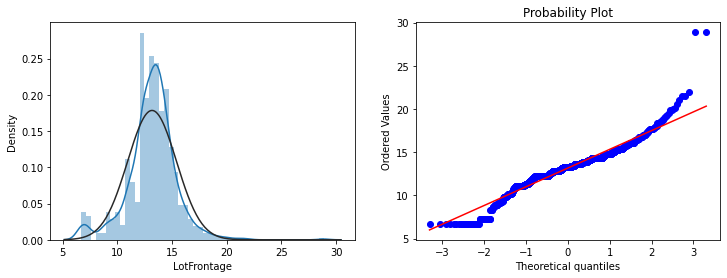

In [46]:
dict_transformed = {}
for i in range(len(pt_cols)):
    dict_transformed[pt_cols[i]] = pt.transform(df_tr[pt_cols])[:,i]
df_transformed = pd.DataFrame(dict_transformed, index=df_tr.index)

for col in pt_cols:
    dist_prob_plot(df_transformed[col])

## 1.6 Outliers
According to the original paper, the author told us that there are some outliers in the dataset. In the above probability plots, you may have already found some the outliers. We can plot a scatter plot of SalePrice versus GrLivArea as a confirmation.

Notice that 4 houses with more than 4000 square feet from the train set may be outliers. 
- 2 houses from Edwards neighborhood are very large but the sales are partial sales, which may not represent actual market values of the houses
- 2 houses from NoRidge neighborhood are priced extremely high

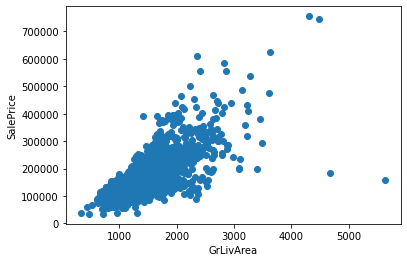

In [47]:
plt.scatter(df_tr['GrLivArea'], df_tr['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [48]:
#check them in detail
df_tr[df_tr['GrLivArea']>4000]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094.0,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260.0,Unf,0.0,878.0,3138.0,GasA,Ex,Y,SBrkr,3138.0,1538.0,0.0,4676.0,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007,Fin,3,884.0,TA,TA,Y,208.0,406.0,0.0,0.0,0.0,0.0,None,None,None,0.0,10,2007,New,Partial,184750
692,60,RL,104.0,21535.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455.0,Unf,0.0,989.0,2444.0,GasA,Ex,Y,SBrkr,2444.0,1872.0,0.0,4316.0,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994,Fin,3,832.0,TA,TA,Y,382.0,50.0,0.0,0.0,0.0,0.0,None,None,None,0.0,1,2007,WD,Normal,755000
1183,60,RL,160.0,15623.0,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096.0,Unf,0.0,300.0,2396.0,GasA,Ex,Y,SBrkr,2411.0,2065.0,0.0,4476.0,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996,Fin,3,813.0,TA,TA,Y,171.0,78.0,0.0,0.0,0.0,555.0,Ex,MnPrv,None,0.0,7,2007,WD,Abnorml,745000
1299,60,RL,313.0,63887.0,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644.0,Unf,0.0,466.0,6110.0,GasA,Ex,Y,SBrkr,4692.0,950.0,0.0,5642.0,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008,Fin,2,1418.0,TA,TA,Y,214.0,292.0,0.0,0.0,0.0,480.0,Gd,None,None,0.0,1,2008,New,Partial,160000


## 1.7 Correlations
Here we simply check the correlations between each variable and the target variable

### 1.7.1 Simple Visualizations
- Numerical variables: scatter plot
- Categorical variables: box plot

**Some interesting insights**:
- Some continuous variables have a quite share of zero values, e.g. 2ndFlrSF, which suggests that we can try to add an indicator variable and see if it can be a better feature than the original one. 
- Some categorical variables contain much information about SalePrice since the SalePrice varies a lot in different categories, e.g. Neighborhood.

In [49]:
def var_scatter_plot(df, feature_list, row_num, col_num, figsize=(20,20)):
    fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
    for i, col_name in enumerate(feature_list):
        ax = axes[int(i/col_num), i%col_num]
        sns.scatterplot(x=col_name, y='SalePrice', data=df[feature_list + ['SalePrice']], ax=ax)
        ax.set_title(col_name)
    plt.tight_layout()

def var_box_plot(df, feature_list, row_num, col_num, figsize=(20,20)):
    fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
    for i, col_name in enumerate(feature_list):
        ax = axes[int(i/col_num), i%col_num]
        sns.boxplot(x=col_name, y='SalePrice', data=df[feature_list + ['SalePrice']], ax=ax)
        ax.set_title(col_name)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()

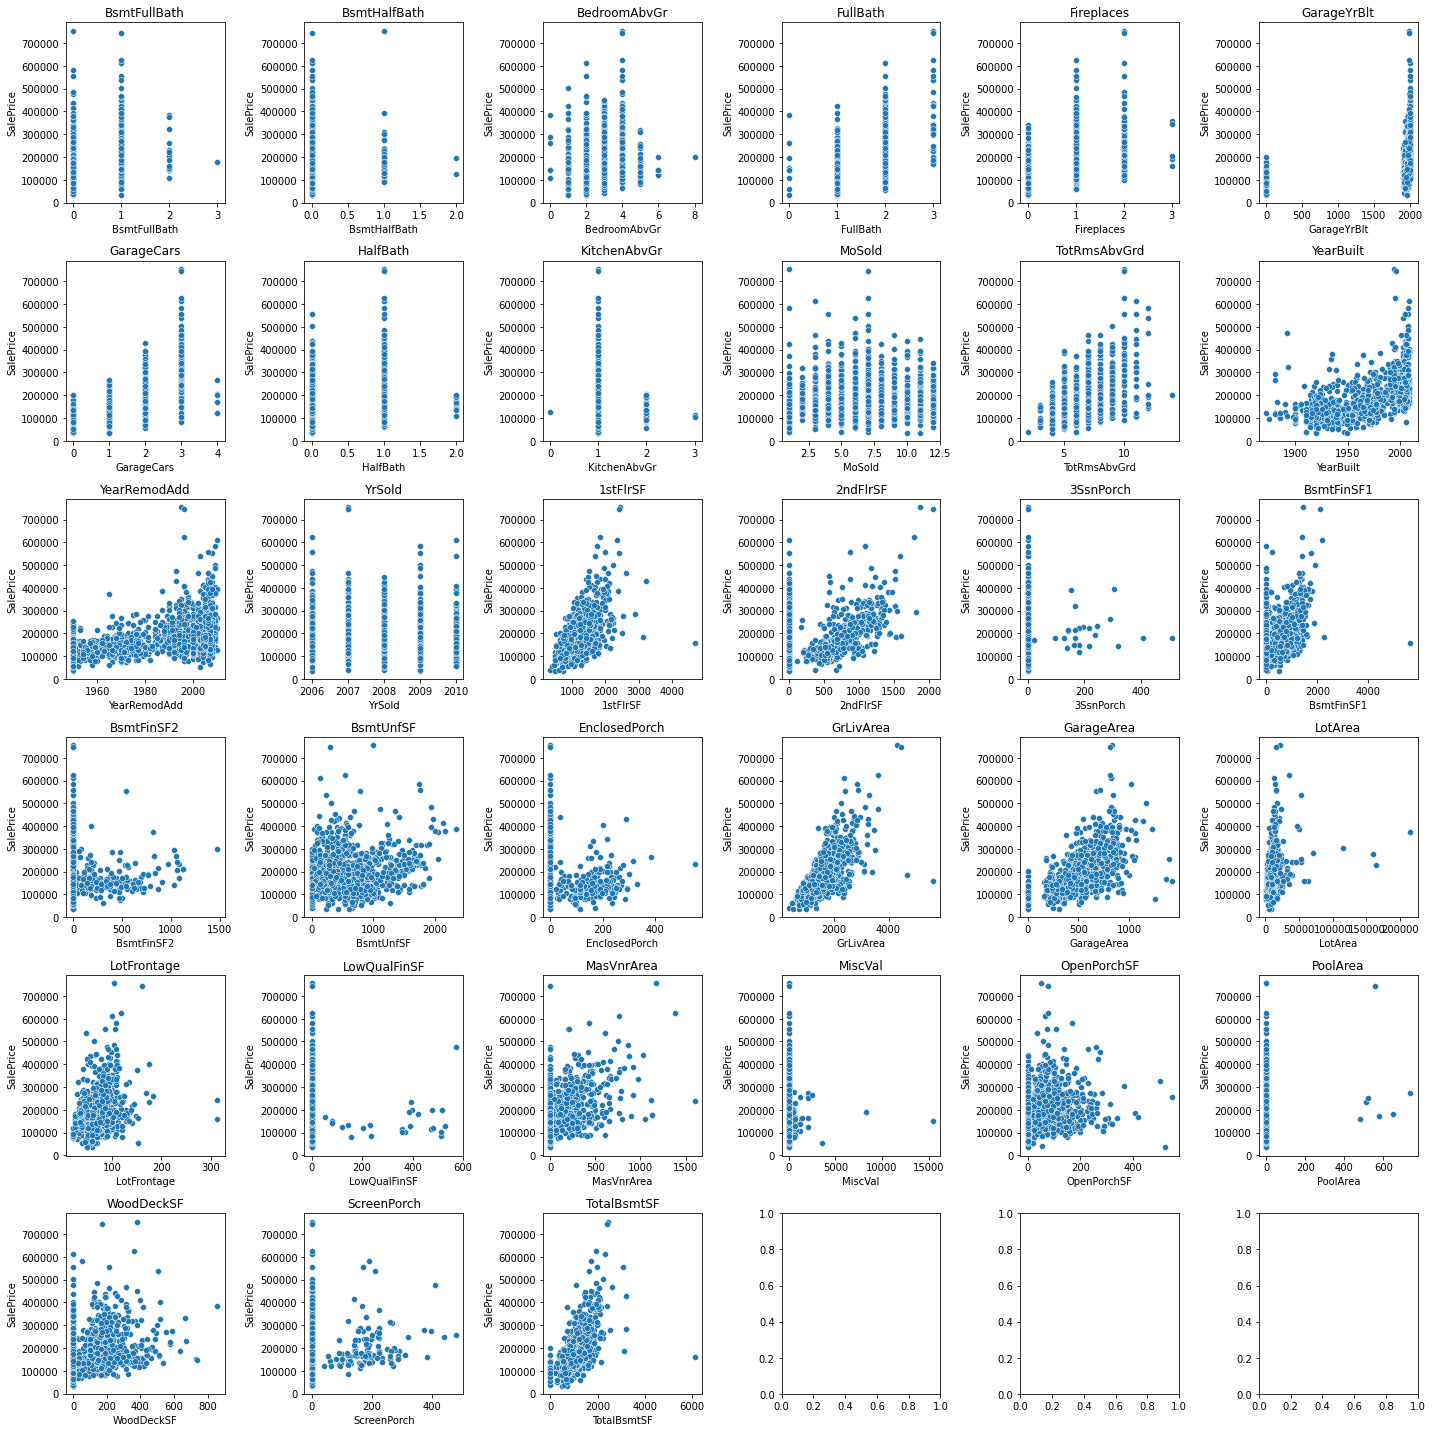

In [50]:
var_scatter_plot(df_tr, NUMERICAL, 6, 6, figsize=(20,20))

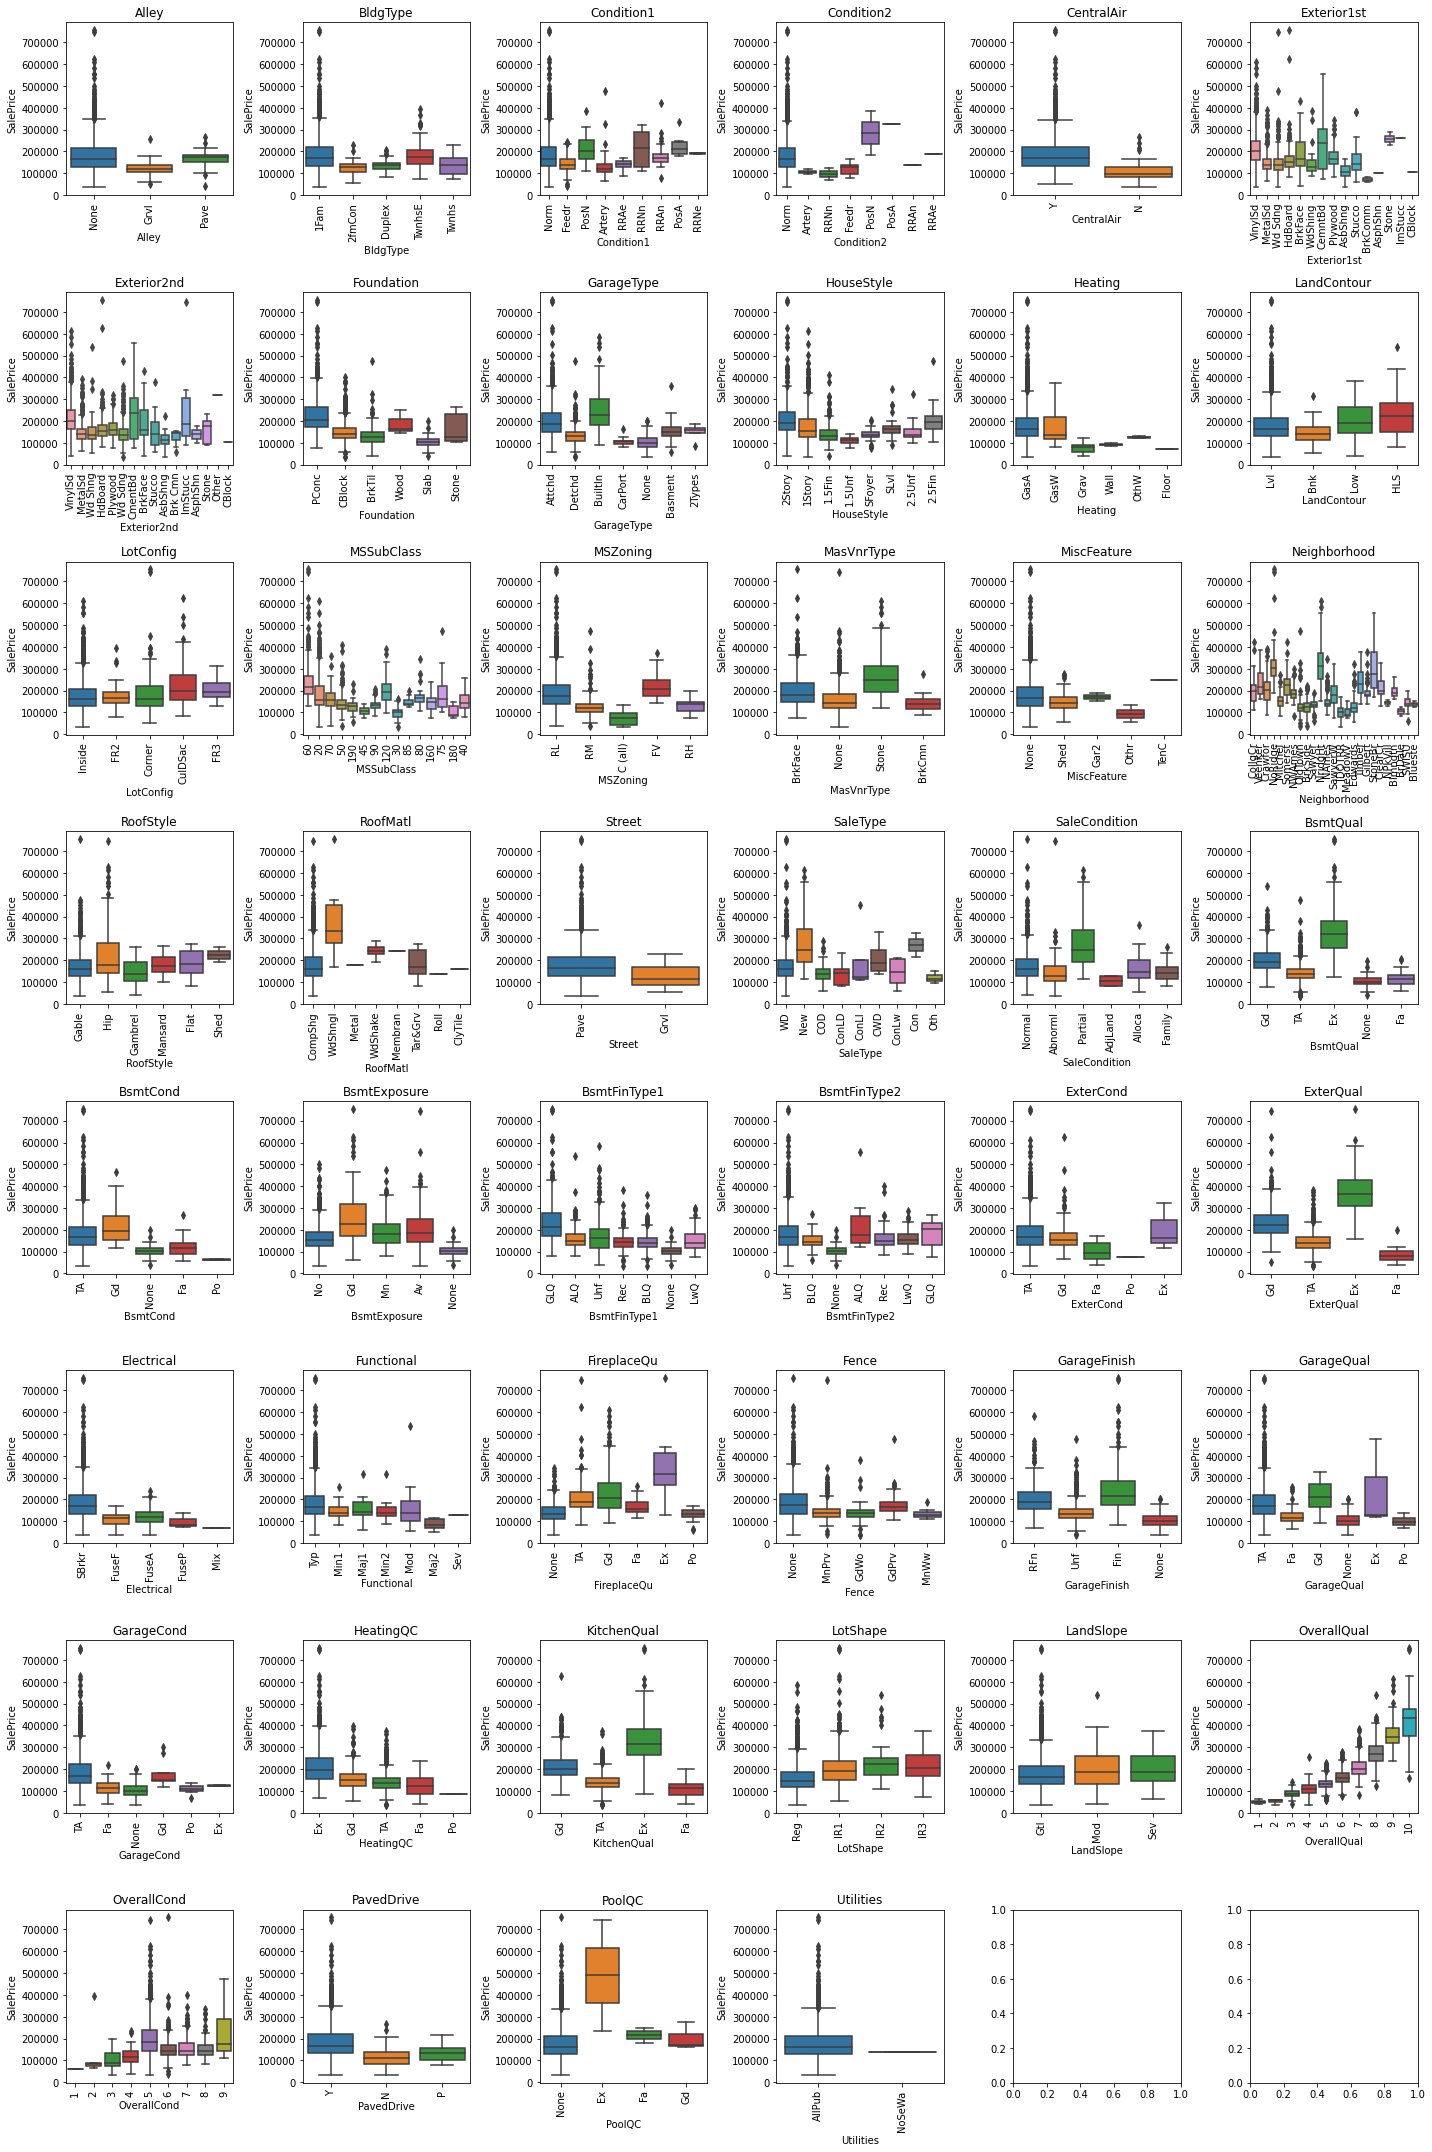

In [51]:
var_box_plot(df_tr, CATEGORICAL, 8, 6, figsize=(20,30))

### 1.7.2 Correlation Coefficients for Numerical Variables
- There are 2 kinds of correlation coefficients for numerical variables: [Pearson and Spearman](https://towardsdatascience.com/clearly-explained-pearson-v-s-spearman-correlation-coefficient-ada2f473b8). Both coefficients can only give linear correlations.
    - For continuous variables: Pearson's correlation
    - For discrete variables: Spearman's rank correlation
- We can do this again later after data preparation part to give suggestions on feature selection. 

**Some highly-correlated pairs (coefficient > 0.8)**:
- TotalBsmtSF, 1stFlrSF: Basements may have generally the same area as the first floor
- YearBuilt, GarageYrBlt: Garages seem to be built in the same year as houses
- GarageArea, GarageCars: Garage area is highly correlated with number of cars which makes sense
- TotRmsAbvGrd, GrLivArea: Number of rooms above grade is highly correlated with living area above grade (ground)

**Other insights**:
- GrLivArea seems to have the highest correlation with SalePrice in all the numerical variables.

In [52]:
def correlation_plot(df, feature_list, method='pearson', figsize=(24,16)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df[feature_list + ['SalePrice']].corr(method=method), vmax=0.8, annot=True, cmap='Blues', ax=ax)
    if method=='pearson':
        plt.title("Pearson's Correlation")
    elif method=='spearman':
        plt.title("Spearman's Rank Correlation")

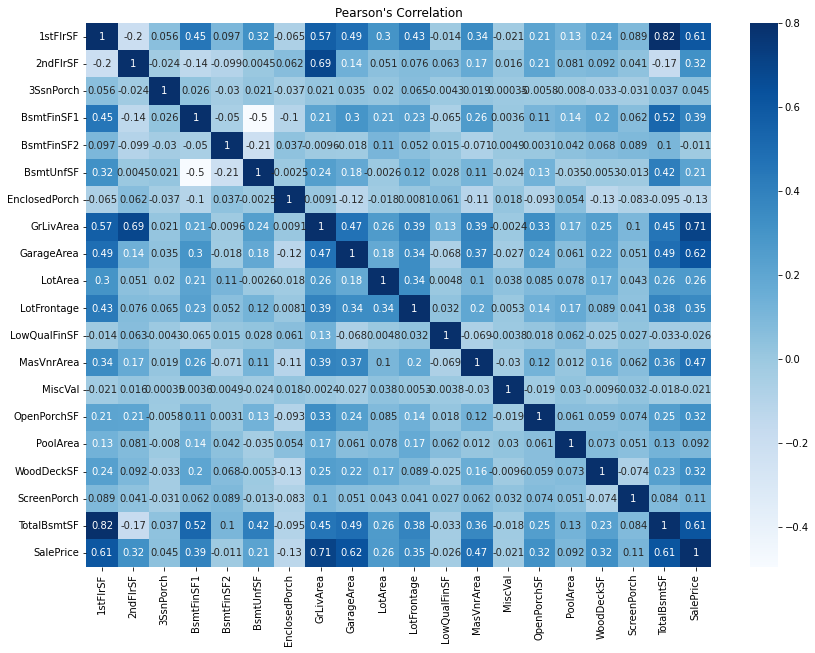

In [53]:
correlation_plot(df_tr, CONTINUOUS, 'pearson', (14,10))

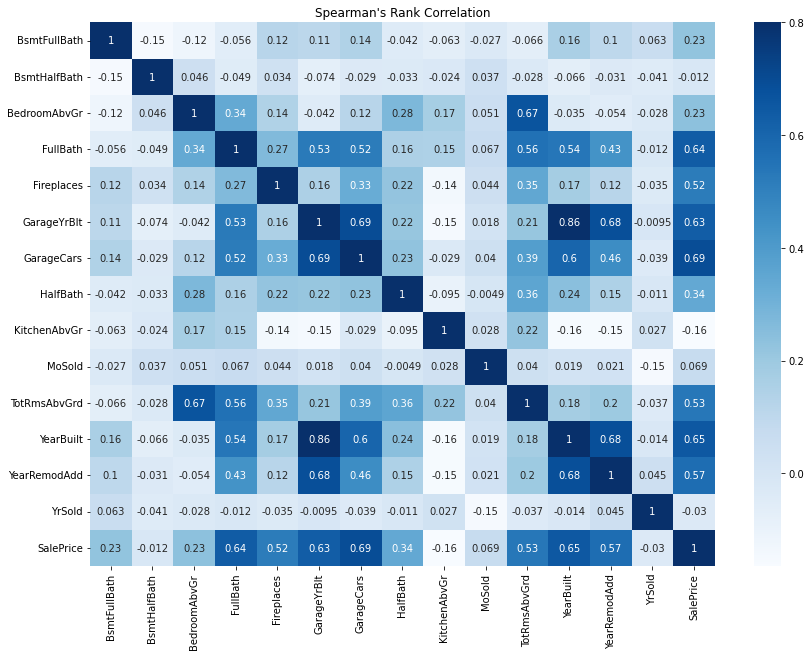

In [54]:
correlation_plot(df_tr, DISCRETE, 'spearman', (14,10))

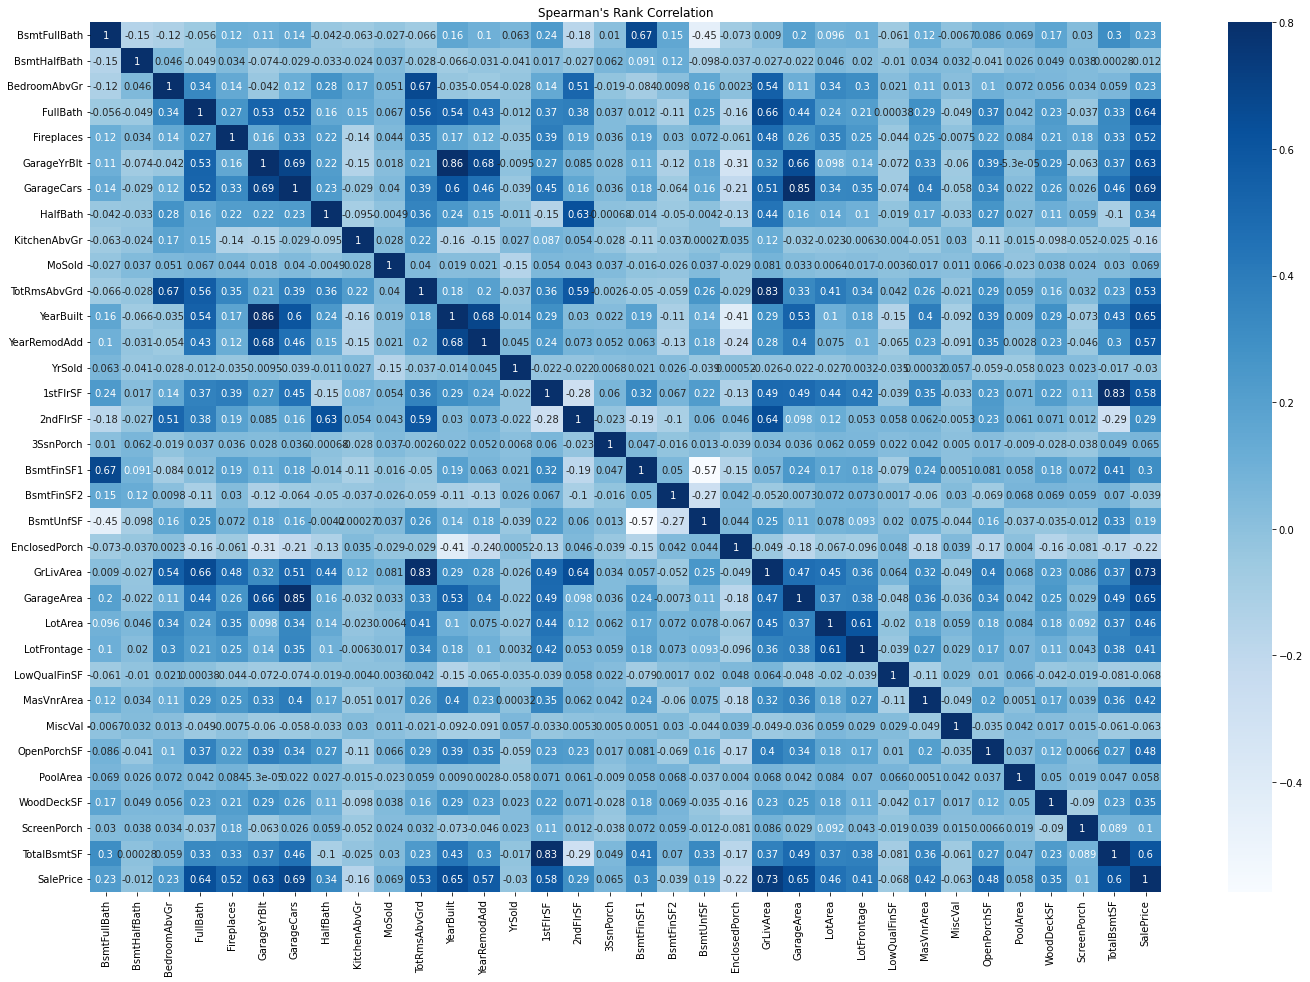

In [55]:
#DISCRETE+CONTINUOUS
correlation_plot(df_tr, NUMERICAL, 'spearman', (24,16))

### 1.7.3 Get Some Insights Between Categorical Variables and GrLivArea
- Here we can also do some bivariate analysis between categorical and numerical variables as well. 
- As an example, we check if there are some relationships between each nominal variable and the size of a house represented by GrLivArea.
    - However, it seems that there aren't many new insights here.


In [56]:
# def GrLivArea_scatter_plot(df, feature_list, row_num, col_num, figsize=(24,16)):
#     fig, axes = plt.subplots(row_num, col_num, figsize=figsize)
#     for i, col_name in enumerate(feature_list):
#         ax = axes[int(i/col_num), i%col_num]
#         sns.scatterplot(x='GrLivArea', y='SalePrice', hue=col_name, s=15, data=df, ax=ax)
#     plt.tight_layout()

In [57]:
# GrLivArea_scatter_plot(df_tr, NOMINAL, 8, 3, figsize=(24,64))

# 2 Data Preparation
What we have already done:
- dealt with missing values and feature types
- checked the distributions of variables
- identified outliers

What needs to be done next:
- remove outliers
- feature engineering
    - create new features
    - deal with multicollearity by removing redundant variables
- apply box-cox transformation on some continuous variables
- categorical variables encoding
    - one-hot for nominal variables
    - ordered label for ordinal variables
- standardization (mean 0 and std 1), but not including dummy variables
- naive feature selection / dimension reduction

## 2.1 Remove Outliers
- Here we just use a naive way according to the suggestion in the original paper.
- If you want to check other outliers, you can use 3$\sigma$ rules.

In [58]:
def remove_outliers(df_tr):
    df = df_tr.copy()
    df = df[df['GrLivArea']<=4000]
    return df

In [59]:
df_tr1 = remove_outliers(df_tr)

## 2.2 Feature Engineering

### 2.2.1 Create New Variables

In [60]:
#feature engineering (create new features, remove multicollinearity)
def create_new_variables(df_tr):
    df = df_tr.copy()
    df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
    df['TotalPorchSF'] = df['3SsnPorch'] + df['EnclosedPorch'] + df['OpenPorchSF'] + df['ScreenPorch'] + df['WoodDeckSF']
    df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']
    
    df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 0 if x==0 else 1)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 0 if x==0 else 1)
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 0 if x==0 else 1)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 0 if x==0 else 1)
    df['HasPorch'] = df['TotalPorchSF'].apply(lambda x: 0 if x==0 else 1)
    
    return df

In [61]:
NEW_VARIABLES = ['TotalSF', 'TotalPorchSF', 'TotalBath', 'Has2ndFlr', 'HasBsmt', 
                 'HasFireplace', 'HasGarage', 'HasPorch']
df_tr2 = create_new_variables(df_tr1)

### 2.2.2 Deal with Multicollearity by Removing Redundant Numerical Variables
Obvious linear relationships:
- GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF
- TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF
- TotalBath = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath
- TotalSF = GrLivArea + TotalBsmtSF
- TotalPorchSF = 3SsnPorch + EnclosedPorch + OpenPorchSF + ScreenPorch + WoodDeckSF

Variable pairs with Pearson's coefficient or Spearman's coefficient > 0.8: 
- high_corr_pairs

Remove redundant variables based on their correlations with SalePrice.

In [62]:
p_corr = df_tr2[NUMERICAL+NEW_VARIABLES+['SalePrice']].corr(method='pearson')
s_corr = df_tr2[NUMERICAL+NEW_VARIABLES+['SalePrice']].corr(method='spearman')

In [63]:
def high_corr_pairs(p_corr, s_corr):
    pairs = []
    for i in range(1, len(p_corr)):
        for j in range(0, i):
            p = abs(p_corr.iloc[i, j])
            s = abs(s_corr.iloc[i, j])
            if s>0.8 or p>0.8:
                pairs.append((p_corr.index[i], p_corr.columns[j]))
                
    return pairs
                
high_corr_pairs(p_corr, s_corr)

[('YearBuilt', 'GarageYrBlt'),
 ('GrLivArea', 'TotRmsAbvGrd'),
 ('GarageArea', 'GarageCars'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('TotalSF', 'GrLivArea'),
 ('Has2ndFlr', '2ndFlrSF'),
 ('HasFireplace', 'Fireplaces'),
 ('HasGarage', 'GarageYrBlt'),
 ('SalePrice', 'TotalSF')]

In [64]:
# p_corr.loc['SalePrice',:]

In [65]:
# s_corr.loc['SalePrice',:]

In [66]:
def remove_multicollinearity(df_tr):
    df = df_tr.copy()
    remove_cols = ['GarageYrBlt', 'GrLivArea', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', 
                   'Fireplaces', 'Has2ndFlr', 'BsmtHalfBath', '3SsnPorch']
    
    return df.drop(remove_cols, axis=1)

In [67]:
df_tr3 = remove_multicollinearity(df_tr2)

In [68]:
#updata feature lists

#continuous
CONTINUOUS_1 = CONTINUOUS + ['TotalSF', 'TotalPorchSF', 'TotalBath']
for col in ['GrLivArea', 'GarageArea', '1stFlrSF', 'TotalBsmtSF', '3SsnPorch']:
    CONTINUOUS_1.remove(col)

#discrete
DISCRETE_1 = DISCRETE + ['Has2ndFlr', 'HasBsmt', 'HasFireplace', 'HasGarage', 'HasPorch']
for col in ['GarageYrBlt', 'Fireplaces', 'Has2ndFlr', 'BsmtHalfBath']:
    DISCRETE_1.remove(col)

NUMERICAL_1 = CONTINUOUS_1 + DISCRETE_1

## 2.3 Variable Transformations
Target variable: log transformation

Feature variables: Box-Cox transformation
- Notice that although TotalBath is float typed, its values are actually discrete, so we don't apply Box-Cox transformation on it.
- To make the transformation more interpretable, based on the values of lambda and [common Box-Cox transformations](https://www.statisticshowto.com/box-cox-transformation/), we apply log transformation on LotArea, square root transformation on LotFrontage and TotalSF.

In [69]:
pt_cols = list(df_tr3[CONTINUOUS_1].min()[df_tr3[CONTINUOUS_1].min()>0].index)
pt = PowerTransformer(method='box-cox', standardize=False)
pt.fit(df_tr3[pt_cols])
for i in range(len(pt_cols)):
    print("{} lambda={}".format(pt_cols[i], round(pt.lambdas_[i], 2)))

LotArea lambda=0.04
LotFrontage lambda=0.57
TotalSF lambda=0.41
TotalBath lambda=0.66


In [70]:
def box_cox_transformation(df_tr):
    df = df_tr.copy()
    if 'SalePrice' in df.columns:
        df['SalePrice'] = np.log1p(df['SalePrice'])
        
    df['LotArea'] = np.log1p(df['LotArea'])
    df['LotFrontage'] = np.sqrt(df['LotFrontage'])
    df['TotalSF'] = np.sqrt(df['TotalSF'])

    return df

In [71]:
df_tr4 = box_cox_transformation(df_tr3)

## 2.4 Categorical Encoding
- Ordinal variables: Ordinal encoding
- Nominal variables: One-Hot encoding

In [72]:
tr_a = box_cox_transformation(
    remove_multicollinearity(
        create_new_variables(
            remove_outliers(df_tr)
        )
    )
)

#don't apply remove_outliers on test set
te_a = box_cox_transformation(
    remove_multicollinearity(
        create_new_variables(df_te)
    )
)

In [73]:
ordinal_map = {'BsmtQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0},
               'BsmtCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0},
               'BsmtExposure':{'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'None':0},
               'BsmtFinType1':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0},
               'BsmtFinType2':{'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'LwQ':2, 'Unf':1, 'None':0},
               'ExterQual':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
               'ExterCond':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
               'Electrical':{'SBrkr':4, 'FuseF':3, 'FuseA':2, 'FuseP':1, 'Mix':0},
               'Functional':{'Typ':7, 'Min1':6, 'Min2':5, 'Mod':4, 'Maj1':3, 'Maj2':2, 'Sev':1, 'Sal':0},
               'FireplaceQu':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0},
               'Fence':{'GdPrv':4, 'MnPrv':3, 'GdWo':2, 'MnWw':1, 'None':0},
               'GarageFinish':{'Fin':3, 'RFn':2, 'Unf':1, 'None':0},
               'GarageQual':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0},
               'GarageCond':{'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0},
               'HeatingQC':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
               'KitchenQual':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0},
               'LotShape':{'Reg':3, 'IR1':2, 'IR2':1, 'IR3':0},
               'LandSlope':{'Gtl':2, 'Mod':1, 'Sev':0},
               'PavedDrive':{'Y':2, 'P':1, 'N':0},
               'PoolQC':{'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'None':0},
               'Utilities':{'AllPub':3, 'NoSewr':2, 'NoSeWa':1, 'ELO':0}
              }

#some categories only exist in test set, so we set handle_unknown='ignore'
one_hot = OneHotEncoder(handle_unknown='ignore').fit(tr_a[NOMINAL])

In [74]:
def categorical_encoding(df_tr, ordinal_map, one_hot, NOMINAL):
    df = df_tr.copy()
    #ordinal encoding
    for col in ordinal_map.keys():
        df[col] = df[col].map(ordinal_map[col])
    
    #one-hot encoding
    new_feature_names = one_hot.get_feature_names(NOMINAL)
    one_hot_df = pd.DataFrame(one_hot.transform(df[NOMINAL]).toarray(), columns=new_feature_names, index=df.index)
    df = pd.concat([df.drop(NOMINAL, axis=1), one_hot_df], axis=1)
    
    return df

In [75]:
tr_b = categorical_encoding(tr_a, ordinal_map, one_hot, NOMINAL)
te_b = categorical_encoding(te_a, ordinal_map, one_hot, NOMINAL)

In [76]:
print(tr_b.shape, te_b.shape)

(1456, 234) (1459, 233)


## 2.5 Standardization
- Ignoring dummy variables, we apply standardization on numerical variables and ordinal variables.

In [77]:
tr_b[NUMERICAL_1+ORDINAL].describe()

,2ndFlrSF,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,LotArea,LotFrontage,LowQualFinSF,MasVnrArea,MiscVal,OpenPorchSF,PoolArea,WoodDeckSF,ScreenPorch,TotalSF,TotalPorchSF,TotalBath,BsmtFullBath,BedroomAbvGr,FullBath,GarageCars,HalfBath,KitchenAbvGr,MoSold,TotRmsAbvGrd,YearBuilt,YearRemodAdd,YrSold,HasBsmt,HasFireplace,HasGarage,HasPorch,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,ExterCond,ExterQual,Electrical,Functional,FireplaceQu,Fence,GarageFinish,GarageQual,GarageCond,HeatingQC,KitchenQual,LotShape,LandSlope,OverallQual,OverallCond,PavedDrive,PoolQC,Utilities
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,343.532967,436.991071,46.677198,566.990385,22.014423,9.107632,8.264247,5.860577,101.526786,43.608516,46.221154,2.055632,93.833791,15.102335,50.012201,180.590659,2.204670,0.423764,2.864698,1.561813,1.764423,0.381181,1.046703,6.326236,6.506181,1971.18544,1984.819368,2007.817308,0.974588,0.526099,0.944368,0.825549,3.48489,2.934753,1.625000,3.539148,1.248626,2.083791,2.392170,3.843407,6.841346,1.819368,0.565247,1.712225,2.809753,2.808379,3.142857,2.507555,2.594780,1.937500,6.088599,5.576236,1.855769,0.008242,2.998626
std,431.528915,430.255052,161.522376,442.197182,61.192248,0.513351,1.268959,48.688904,177.011773,496.799265,65.352424,35.383772,125.192349,55.828405,7.481908,156.078859,0.778141,0.517420,0.815800,0.547683,0.746215,0.502533,0.220627,2.698356,1.611800,30.20159,20.652143,1.329394,0.157427,0.499490,0.229288,0.379627,0.87409,0.552906,1.062077,2.106734,0.892888,0.351509,0.570206,0.531028,0.668563,1.809386,1.204174,0.891511,0.723822,0.720604,0.959770,0.660062,0.578492,0.276593,1.369669,1.113966,0.497217,0.157081,0.052414
min,0.000000,0.000000,0.000000,0.000000,0.000000,7.170888,4.582576,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.275667,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1872.00000,1950.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,222.500000,0.000000,8.927944,7.745967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.872039,45.000000,2.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,5.000000,5.000000,1954.00000,1966.750000,2007.000000,1.000000,0.000000,1.000000,1.000000,3.00000,3.000000,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,1.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,5.000000,5.000000,2.000000,0.000000,3.000000
50%,0.000000,381.000000,0.000000,477.500000,0.000000,9.155831,8.366600,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,49.749372,164.000000,2.000000,0.000000,3.000000,2.000000,2.000000,0.000000,1.000000,6.000000,6.000000,1972.00000,1993.500000,2008.000000,1.000000,1.000000,1.000000,1.000000,4.00000,3.000000,1.000000,4.000000,1.000000,2.000000,2.000000,4.000000,7.000000,2.000000,0.000000,2.000000,3.000000,3.000000,4.000000,2.000000,3.000000,2.000000,6.000000,5.000000,2.000000,0.000000,3.000000
75%,728.000000,706.500000,0.000000,808.000000,0.000000,9.357811,8.944272,0.000000,163.250000,0.000000,68.000000,0.000000,168.000000,0.000000,54.808758,265.000000,2.500000,1.00

In [78]:
tr_b_X = tr_b.loc[:, tr_b.columns != 'SalePrice']
train_y = tr_b['SalePrice']

scalar = StandardScaler()
scalar.fit(tr_b_X[NUMERICAL_1+ORDINAL])

StandardScaler()

In [79]:
def standardization(df_tr, scalar, NUMERICAL_1, ORDINAL):
    df = df_tr.copy()
    scale_X = scalar.transform(df[NUMERICAL_1+ORDINAL])
    scale_df = pd.DataFrame(scale_X, columns=NUMERICAL_1+ORDINAL, index=df.index)
    non_scale_df = df.drop(NUMERICAL_1+ORDINAL, axis=1)
    df = pd.concat([scale_df, non_scale_df], axis=1)
    
    return df

In [80]:
train_X_scaled = standardization(tr_b_X, scalar, NUMERICAL_1, ORDINAL)
test_X_scaled = standardization(te_b, scalar, NUMERICAL_1, ORDINAL)

## 2.6 Dimensionality Reduction
- For now we have 233 features totally. The dimension is very high compared with sample size.
- We can do some naive feature selection, e.g. remove the least correlated features to SalePrice and remove multicollinearity based on pairwise correlations.
- Here we use PCA to get the most informative directions instead, which is a good way to reduce dimension, as well as remove multicollinearity and noise. It can also act as a regularizer.Dimensionality Reduction

### 2.6.1 Pairwise Correlations

In [81]:
p_corr_b = pd.concat([train_X_scaled, train_y], axis=1).corr(method='pearson')
s_corr_b = pd.concat([train_X_scaled, train_y], axis=1).corr(method='spearman')

In [82]:
high_corr_pairs(p_corr_b, s_corr_b)

[('BsmtCond', 'HasBsmt'),
 ('BsmtFinType2', 'BsmtFinSF2'),
 ('FireplaceQu', 'HasFireplace'),
 ('GarageQual', 'HasGarage'),
 ('GarageCond', 'HasGarage'),
 ('GarageCond', 'GarageQual'),
 ('PoolQC', 'PoolArea'),
 ('CentralAir_Y', 'CentralAir_N'),
 ('Exterior2nd_AsbShng', 'Exterior1st_AsbShng'),
 ('Exterior2nd_CBlock', 'Exterior1st_CBlock'),
 ('Exterior2nd_CmentBd', 'Exterior1st_CemntBd'),
 ('Exterior2nd_HdBoard', 'Exterior1st_HdBoard'),
 ('Exterior2nd_MetalSd', 'Exterior1st_MetalSd'),
 ('Exterior2nd_VinylSd', 'Exterior1st_VinylSd'),
 ('Exterior2nd_Wd Sdng', 'Exterior1st_Wd Sdng'),
 ('Foundation_Slab', 'HasBsmt'),
 ('GarageType_None', 'HasGarage'),
 ('GarageType_None', 'GarageQual'),
 ('GarageType_None', 'GarageCond'),
 ('HouseStyle_1Story', '2ndFlrSF'),
 ('HouseStyle_2Story', '2ndFlrSF'),
 ('MSSubClass_190', 'BldgType_2fmCon'),
 ('MSSubClass_45', 'HouseStyle_1.5Unf'),
 ('MSSubClass_50', 'HouseStyle_1.5Fin'),
 ('MSSubClass_80', 'HouseStyle_SLvl'),
 ('MSSubClass_90', 'BldgType_Duplex'),
 ('

### 2.6.2 Features Most Correlated to SalePrice

In [83]:
print("Most correlated features (Pearson's) ")
print(p_corr_b['SalePrice'].abs().sort_values(ascending=False).iloc[1:11])

print("\nMost correlated features (Spearman's) ")
print(s_corr_b['SalePrice'].abs().sort_values(ascending=False).iloc[1:11])

print("\nLeast correlated features (Pearson's) ")
print(p_corr_b['SalePrice'].abs().sort_values(ascending=False).tail(10))

print("\nLeast correlated features (Spearman's) ")
print(s_corr_b['SalePrice'].abs().sort_values(ascending=False).tail(10))

Most correlated features (Pearson's) 
TotalSF         0.820657
OverallQual     0.819240
ExterQual       0.680947
GarageCars      0.680408
TotalBath       0.672929
KitchenQual     0.667174
BsmtQual        0.615225
GarageFinish    0.604917
FullBath        0.590919
YearBuilt       0.588977
Name: SalePrice, dtype: float64

Most correlated features (Spearman's) 
TotalSF         0.815471
OverallQual     0.810285
TotalBath       0.703547
GarageCars      0.689725
ExterQual       0.684096
BsmtQual        0.677582
KitchenQual     0.672413
YearBuilt       0.653375
FullBath        0.634599
GarageFinish    0.633461
Name: SalePrice, dtype: float64

Least correlated features (Pearson's) 
Foundation_Wood      0.009242
Condition2_RRAe      0.008795
LotConfig_Corner     0.006909
BsmtFinSF2           0.006420
RoofStyle_Mansard    0.006229
LotConfig_FR2        0.005904
RoofMatl_Metal       0.005215
SaleType_ConLI       0.003400
MiscFeature_Gar2     0.001837
MSSubClass_80        0.000061
Name: SalePrice, d

### 2.6.3 PCA
- The first 50 principal components can explain >90% of variance in the original data set.
- The first 100 principal components can explain nearly 99% variance in the original data set.

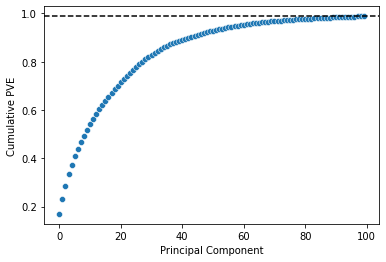

In [84]:
pca = PCA(n_components=100)
pca.fit(train_X_scaled)
pve = pca.explained_variance_ratio_

sns.scatterplot(x=range(0, len(pve)), y=pve.cumsum())
plt.axhline(y=0.99, c='black', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative PVE')
plt.show()

In [85]:
def dimension_reduction(df_tr, pca):
    df = df_tr.copy()
    return pca.transform(df)

In [86]:
train_X = dimension_reduction(train_X_scaled, pca)
test_X = dimension_reduction(test_X_scaled, pca)
print(train_X.shape, test_X.shape)

(1456, 100) (1459, 100)


# 3 Modelling

## 3.1 Simple Models
In this part, we build some basic models mostly using default hyperparameters without tuning and check the results. (Got some thoughts from [here](https://www.kaggle.com/code/massquantity/all-you-need-is-pca-lb-0-11421-top-4#Modeling-&-Evaluation))

In [87]:
models_dict = {'LR': LinearRegression(),
               'RIDGE': Ridge(),
               'Lasso': Lasso(alpha=0.01,max_iter=10000),
               'ENet': ElasticNet(alpha=0.001,max_iter=10000),
               'SVR': SVR(),
               'LinSVR': LinearSVR(),
               'KNN': KNeighborsRegressor(),
               'Kernel': KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
               'RF': RandomForestRegressor(),
               'AdaBoost': AdaBoostRegressor(),
               'ExTree': ExtraTreesRegressor(),
               'Xgb': XGBRegressor()
              }

In [88]:
def rmse_cv(model, train_X, train_y):
    rmse = np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [89]:
for name in models_dict.keys():
    np.random.seed(42)
    rmse = rmse_cv(models_dict[name], train_X, train_y)
    print('{}: {:.6f}'.format(name, rmse.mean()))

LR: 0.440231
RIDGE: 0.118789
Lasso: 0.135607
ENet: 0.115351
SVR: 0.151957
LinSVR: 0.156107
KNN: 0.172538
Kernel: 0.113708
RF: 0.142413
AdaBoost: 0.159554
ExTree: 0.139640
Xgb: 0.143141


## 3.2 Cross-validation and Hyperparameter Tuning
Here we need to do hyperparameter tuning for each model and choose the model with the best performance. To avoid leakage, we can choose to apply nested cross-validation, which means we tune hyperparameters on an inner cross-validation and choose the best model on an outer cros-validation.

In [90]:
def hyper_tuning_cv(train_X, train_y, model, param_grid, if_nested=True):
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    if if_nested:
        #nested CV with hyperparameter tuning
        reg = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='neg_mean_squared_error')
        score = np.sqrt(-cross_val_score(reg, train_X, train_y, scoring='neg_mean_squared_error', cv=outer_cv))
    else:
        # Non_nested parameter search and scoring
        reg = GridSearchCV(estimator=model, param_grid=param_grid, cv=outer_cv, scoring='neg_mean_squared_error')
        reg.fit(train_X, train_y)
        score = np.sqrt(-reg.best_score_)
    
    return score.mean()


In [91]:
hyper_tuning_cv(train_X, train_y, Lasso(), {'alpha': [0.01,0.05,0.001,0.005,0.0001,0.0005]}, True)

0.11581415215103794

In [92]:
hyper_tuning_cv(train_X, train_y, Lasso(), {'alpha': [0.01,0.05,0.001,0.005,0.0001,0.0005]}, False)

0.11553373588582994

In [93]:
hyper_tuning_cv(train_X, train_y, Ridge(), {'alpha': [50,30,10,1,0.1]}, True)

0.1142101684094454

In [94]:
hyper_tuning_cv(train_X, train_y, Ridge(), {'alpha': [50,30,10,1,0.1]}, False)

0.11414816842130139

# 4 Submission

In [95]:
model = Ridge()
model.fit(train_X, train_y)
pred = np.exp(model.predict(test_X)) - 1

result = pd.DataFrame({'Id': df_te.index, 'SalePrice': pred})
result.to_csv('submission.csv', index=False)